In [3]:
# Preamble/imports
import pandas as pd # for df manipulation
import numpy as np # for additional data analysis functionality
import missingno as msno # for missing number analysis
import seaborn as sns # for data visualisation
import matplotlib.pyplot as plt # for data visualisation
import datetime as dt # for manipulation of the date column
import copy # for deep copying the dataset class, so we can have both joint and separate analysis

# JB's imports for the geographical graph
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

from sklearn import linear_model # For regression analysis
from sklearn import datasets
from sklearn.decomposition import PCA # For Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay


In [4]:
# Merge independent and dependent variables into one file
training_dep_var = pd.read_csv('Training set labels.csv') # , index_col=0
training_indep_vars = pd.read_csv('Training set values.csv')
training_df = training_dep_var.merge(training_indep_vars, on='id')

In [5]:
# assign testing values
test_df = pd.read_csv('Test set values.csv')

In [6]:
#CHECK
training_df[training_df.columns[training_df.isnull().any()]]

,funder,installer,subvillage,public_meeting,scheme_management,scheme_name,permit
0,Roman,Roman,Mnyusi B,True,VWC,Roman,False
1,Grumeti,GRUMETI,Nyamara,NaN,Other,NaN,True
2,Lottery Club,World vision,Majengo,True,VWC,Nyumba ya mungu pipe scheme,True
3,Unicef,UNICEF,Mahakamani,True,VWC,NaN,True
4,Action In A,Artisan,Kyanyamisa,True,NaN,NaN,True
...,...,...,...,...,...,...,...
59395,Germany Republi,CES,Kiduruni,True,Water Board,Losaa Kia water supply,True
59396,Cefa-njombe,Cefa,Igumbilo,True,VWC,Ikondo electrical water sch,True
59397,NaN,NaN,Madungulu,True,VWC,NaN,False
59398,Malec,Musa,Mwinyi,True,VWC,NaN,True


In [10]:
# a = training_df.loc[(training_df['amount_tsh']==0) & (training_df['status_group']=='functional needs repair'), 'amount_tsh'].value_counts().sum()
# print(a/4317)
# #in need of repair
# b = training_df.loc[(training_df['amount_tsh']==0) & (training_df['status_group']=='functional'), 'amount_tsh'].value_counts().sum()
# print(b/32359)
# #functional
# c = training_df.loc[(training_df['amount_tsh']==0) & (training_df['status_group']=='non functional'), 'amount_tsh'].value_counts().sum()
# print(c/22824)
# #non functional 
training_df['water']

KeyError: 'water'

In [11]:
#keep: 'region_code', 'district_code', 'waterpoint_type',, 'payment', 'quality_group'
# 'quantity_group', 'source_type', 'extraction_type_group', 'extraction_type', 'num_private', 
# 'scheme_management', 'management', 'public_meeting'

# training_df.loc[training_df['status_group'] == 'dry','quantity']
q = training_df['quantity'].value_counts().count()

# for i in range(q):
#     print(i)

q1 = training_df['quantity'].unique().tolist()

for i in q1:
    print(i)

enough
insufficient
dry
seasonal
unknown


In [6]:
class Dataset:
    #use training_data as we will use same class for testing
    def __init__(self, data, training_data=None):
        self.df = data.copy()
        self.ids = self.df['id']
        self.nans_col = 'NaNs'
        self.dep_var = 'status_group'
        self.cat_cols = ['funder', 'installer', 'basin', 'region', 'permit', 'extraction_type_class', 'management_group', 'payment_type', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'quantity_group', 'extraction_type']
        #self.cat_cols = ['quantity']
        self.training_data = training_data
    

    def convert_datetime(self):
        #initial cleaning
        #convert dates to datetime
        self.df['date_recorded'] = pd.to_datetime(self.df['date_recorded'])
    
    def convert_missing_values(self, training_data=True, pointon_analysis = False, braganza = False):
        #missing values
        self.df.loc[self.df['longitude']==0.0, 'longitude'] = np.nan #where the longitude values are 0.0 replace with NaN
        self.df.loc[self.df['latitude']==-2.000000e-08, 'latitude'] = np.nan #replace negative latitude with NaN
        self.df.loc[self.df['construction_year']==0, 'construction_year'] = np.nan #replace construction year of 0 with NaN
        self.df.loc[(self.df['population']==0), 'population'] = np.nan
        self.df.loc[(self.df['population'] > 50000), 'population'] = np.nan
        self.df.loc[self.df['installer']=='0', 'installer'] = np.nan
        self.df.loc[self.df['installer']=='-', 'installer'] = np.nan
        self.df.loc[self.df['funder']=='0', 'funder']= 'unknown'
        self.df.loc[self.df['amount_tsh']>400, 'amount_tsh'] = np.nan
        self.df.loc[self.df['date_recorded']<pd.Timestamp(2010, 1, 1), 'date_recorded'] = self.df.loc[self.df['date_recorded']<pd.Timestamp(2010, 1, 1), 'date_recorded'] + pd.offsets.DateOffset(years=10)
        
        ## For RF keep gps_height unchanged
        #self.df.loc[self.df['gps_height']==0, 'gps_height'] = np.nan #replace gps height 0 with NaN
        #self.df['gps_height'] = abs(self.df['gps_height']) #gps_height is an important feature

        if training_data and pointon_analysis:
            self.df.loc[(self.df['amount_tsh']==0) & (self.df['status_group']=='functional'), 'amount_tsh'] = np.nan # very likely to be incorrect
            self.df.loc[(self.df['amount_tsh']==0) & (self.df['status_group']=='non functional'), 'amount_tsh'] = np.nan # very likely to be incorrect
            self.df.loc[self.df['gps_height']==0, 'gps_height'] = np.nan #replace gps height 0 with NaN
            self.df['gps_height'] = abs(self.df['gps_height']) #gps_height is an important feature
    
        #self.df[self.df['installer].str.contains("gov")].value_counts('installer)

        if braganza: #and training_data
            #Replace public_meeting and scheme_management NaN values with other and unknown respectively
            # public_meeting = 3334 NaNs
            # scheme_management = 3877 NaNs
            self.df.loc[self.df['public_meeting'].isnull(), 'public_meeting'] = 'other'
            self.df['public_meeting'] = self.df['public_meeting'].astype(str)

            self.df.loc[self.df['scheme_management'].isnull(), 'scheme_management'] = 'unknown'
            self.df['scheme_management'] = self.df['scheme_management'].astype(str)

            self.df.loc[self.df['amount_tsh'].isnull(), 'amount_tsh'] = 0
            self.df.loc[self.df['longitude'].isnull(), 'longitude'] = 0
            self.df.loc[self.df['latitude'].isnull(), 'latitude'] = 0


    def convert_missing_to_unkown(self):
        # Converting NaNs to unknown
        self.df['permit'] = self.df['permit'].astype(str) #convert all values in permit column to strings, astype casts variables
        self.df.loc[(self.df['permit']!='True') & (self.df['permit']!='False'), 'permit'] = 'unknown' #permits are either true or false so any other than this are NaN
        
        self.df['public_meeting'] = self.df['public_meeting'].astype(str)
        self.df.loc[(self.df['public_meeting']!='True') & (self.df['public_meeting']!='False'), 'public_meeting'] = 'unknown'

        #other columns
        self.df.loc[pd.isnull(self.df['funder']), 'funder'] = 'unknown'
        self.df.loc[pd.isnull(self.df['installer']), 'installer'] = 'unknown'
    # def create_new_attributes(self):
    #     # Attribute creation/manipulation
    #     self.df['age'] = self.df['date_recorded'].dt.year-self.df['construction_year'] # create age col - keep as float due to no NaN representation for ints

    def convert_lowercase(self):
        #convert everything tpo lowercase to remove case errors
        for col in self.df.columns:
            if self.df[col].dtype==object:
                self.df[col] = self.df[col].str.lower()

    def group_infrequent_occurances(self):
        self.df['funder_counts'] = self.df.groupby(['funder'])['funder'].transform('count') #create new column which be number of times funder is listed
        self.df['installer_counts'] = self.df.groupby(['installer'])['installer'].transform('count')
        
        self.df.loc[self.df['installer']=='central government', 'installer'] = 'government'
        self.df.loc[self.df['installer']=='gover', 'installer']= 'government'
        self.df.loc[self.df['installer_counts']<400, 'installer'] = 'other'
        self.df.loc[self.df['funder_counts']<400, 'funder'] = 'other'

    def encode_dep_var(self):
        #encoding the dependent variables with numbers
        self.df['status_group_encoding'] = self.df['status_group'].replace("non functional", 0)
        self.df['status_group_encoding'].replace("functional needs repair", 1, inplace=True)
        self.df['status_group_encoding'].replace("functional", 2, inplace=True)
        #self.df.drop(columns=['status_group'], inplace=True)
    
    def drop_unnecessary_cols(self, pointon_analysis=False, braganza=False):
        #All the columns I'm dropping, REVIEW
        #Dropping quality_group as water_quality seems better! Same for source/type/class - generally the smalled subgroups have different distributions (more non-functional pumps!!)

        if pointon_analysis:
            self.df.drop(columns=['id', 'recorded_by', 'region_code', 'district_code', 'funder_counts', 'installer_counts', 'payment', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', 'extraction_type_group', 'extraction_type', 'num_private', 'wpt_name', 'scheme_name', 'scheme_management', 'management', 'public_meeting'], inplace=True)
            #df.rename(columns={'payment_type': 'payment'})
        if braganza:
            #keep: 'region_code', 'district_code', 'waterpoint_type',, 'payment', 'quality_group'
            # 'quantity_group', 'source_type', 'extraction_type_group', 'extraction_type', 'num_private', 
            # 'scheme_management', 'management', 'public_meeting'
            self.df.drop(columns=['id', 'recorded_by', 'funder_counts', 'installer_counts', 'source_class', 'wpt_name', 'scheme_name', 'payment', 'quality_group', 'source_type', 'extraction_type_group', 'num_private', 'wpt_name', 'scheme_name', 'scheme_management', 'management', 'public_meeting'], inplace=True)
            # 'extraction_type', 'scheme_management'


    def update_nans_col(self):
        #create a new column of NaNs which tells how many NaNs are in the row
        self.df[self.nans_col] = self.df.isna().sum(1)

    def remove_dups(self):
        # find duplicates
        self.update_nans_col()
        non_dup_criteria = ['id', self.nans_col, 'amount_tsh', 'gps_height','quantity','population', 'construction_year', 'permit', 'funder', 'installer', 'date_recorded'] 
        # By including 'date_recorded', this means that any similar ones with different dates are counted as dups and therefore deleted
        #gather all column with duplicated data
        dup_criteria = [e for e in self.df.columns.tolist() if e not in non_dup_criteria]
        #storing all the duplicates for later use?
        dups = self.df[self.df.duplicated(keep=False, subset=dup_criteria)].sort_values(by=dup_criteria+[self.nans_col])

        #removing dups, sort values by columns we want to drop duplicates and 'Number of NaNs in a row' column
        self.df.sort_values(by=dup_criteria+[self.nans_col], inplace=True)
        self.df.drop_duplicates(subset=dup_criteria, keep='first', inplace= True)
        #df.sort_values(nans_col, ascending=False)

    def sort_index(self):
        #sorts index in ascending order and updates it
        self.df.sort_index(inplace=True)
        #delete current index and replace with numeric index
        self.df.reset_index(drop=True, inplace=True)

    def initial_cleaning(self, training_data=True, pointon_analysis = False, braganza = False):
        #this function executes the functions above
        self.convert_datetime()
        self.convert_missing_values(training_data=training_data, pointon_analysis= pointon_analysis, braganza=braganza)
        self.convert_missing_to_unkown()
        self.convert_lowercase()
        self.group_infrequent_occurances()
        self.drop_unnecessary_cols(pointon_analysis=pointon_analysis, braganza=braganza)
        if training_data:
            self.encode_dep_var()
            self.remove_dups()
        self.sort_index()
        #self.create_new_attributes()
        

    def long_lat_imputation(self):
        #Using a shapefile to approximate GPS data by ward
        ward_shape_file = gpd.read_file('2012 Wards Shapefiles/TZwards.shp') # from https://data.humdata.org/dataset/cod-ab-tza
        ward_shape_file['approx_longitude'] = ward_shape_file.centroid.x
        ward_shape_file['approx_latitude'] = ward_shape_file.centroid.y
        ward_shape_file.rename(columns={'Ward_Name': 'ward'}, inplace=True)
        ward_gps = ward_shape_file.sort_values('ward').groupby('ward').mean()[['approx_longitude', 'approx_latitude']]
        ward_gps.reset_index(inplace=True)
        ward_gps['ward'] = ward_gps['ward'].str.lower()

        #Merge it with main df
        self.df = pd.merge(self.df, ward_gps, on='ward', how='left')
        longitude_correls = self.df[['longitude', 'approx_longitude']].corr()
        print(longitude_correls)
        print(self.df[['latitude', 'approx_latitude']].corr())
        print(f'Therefore a very accurate approximation as {round(pd.DataFrame(longitude_correls).iloc[0,1],2)} correlation \n')

        #Using the approximations to fill in the missing values
        self.df.loc[pd.isnull(self.df['longitude']), 'longitude'] = self.df['approx_longitude']
        self.df.loc[pd.isnull(self.df['latitude']), 'latitude'] = self.df['approx_latitude']
        self.df.drop(columns=['approx_longitude', 'approx_latitude'], inplace=True)

        # For the remaining 96 we will use the region/basin subgroup average as their entire ward is without GPS data
        self.df['longitude'] = self.df['longitude'].fillna(self.df.groupby(['region', 'basin'])['longitude'].transform('mean'))
        self.df['latitude'] = self.df['latitude'].fillna(self.df.groupby(['region', 'basin'])['latitude'].transform('mean'))

        #then round to 8
        self.df['longitude'] = self.df['longitude'].round(8)
        self.df['latitude'] = self.df['latitude'].round(8)

    def gps_height_imputation(self, training_data=True):
        if training_data:
            dataset='training'
        else:
            dataset = 'test'
    
        altitudes = pd.read_csv(f'{dataset}_altitude_data.csv') # https://www.gpsvisualizer.com/convert_input?form=elevation
        altitudes.drop_duplicates(inplace=True)
        self.df = self.df.merge(altitudes, how='left', on=['longitude', 'latitude'])
        self.df['gps_height'].fillna(self.df['altitude'], inplace=True)
        self.df.drop(columns=['altitude'], inplace=True)

    def mean_imputation(self, attribute: str, subgroups: list):
        # Imputation - using subgroup imputation as no capacity for Tobit GLM regression in scikit
        self.df[attribute] = self.df[attribute].fillna(self.df.groupby(subgroups)[attribute].transform('mean')) 

    def amount_tsh_imputation(self, training_data=True):
        # Amount_tsh imputation
        if training_data:
            self.mean_imputation('amount_tsh', ['waterpoint_type_group', 'extraction_type_class', 'region', 'status_group'])
        self.mean_imputation('amount_tsh', ['waterpoint_type_group', 'extraction_type_class', 'region'])
        self.mean_imputation('amount_tsh', ['waterpoint_type_group', 'extraction_type_class'])
        self.mean_imputation('amount_tsh', ['extraction_type_class']) # do we want waterpoint type or extraction type?
        self.mean_imputation('amount_tsh', ['waterpoint_type_group'])

    def construction_year_imputation(self, training_data=True, pointon_analysis=False, braganza=False):
        # Construction year imputation
        if training_data:
            self.mean_imputation('construction_year', ['basin', 'region', 'lga', 'ward', 'subvillage'])
            self.mean_imputation('construction_year', ['basin', 'region', 'lga', 'ward'])
            self.mean_imputation('construction_year', ['basin', 'region', 'lga'])
            self.mean_imputation('construction_year', ['basin', 'region'])
            self.mean_imputation('construction_year', ['basin', 'waterpoint_type_group', 'extraction_type_class'])
            self.mean_imputation('construction_year', ['basin', 'waterpoint_type_group'])
            self.mean_imputation('construction_year', ['waterpoint_type_group'])
        else:
            for index, row in self.df.iterrows():
                if pd.isna(row['construction_year']):
                    value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['region']==row['region']) & (self.training_data['lga']==row['lga']) & (self.training_data['ward']==row['ward']) & (self.training_data['subvillage']==row['subvillage'])]['construction_year'].mean()
                    if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                        value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['region']==row['region']) & (self.training_data['lga']==row['lga']) & (self.training_data['ward']==row['ward'])]['construction_year'].mean()
                        if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                            value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['region']==row['region']) & (self.training_data['lga']==row['lga'])]['construction_year'].mean()
                            if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                                value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['region']==row['region'])]['construction_year'].mean()
                                if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                                    value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['waterpoint_type_group']==row['waterpoint_type_group']) & (self.training_data['extraction_type_class']==row['extraction_type_class'])]['construction_year'].mean()
                                    if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                                        value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['waterpoint_type_group']==row['waterpoint_type_group'])]['construction_year'].mean()
                                        if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                                            value = self.training_data.loc[(self.training_data['waterpoint_type_group']==row['waterpoint_type_group'])]['construction_year'].mean()
                    self.df.loc[index, 'construction_year'] = value
                else:
                    pass
        self.df['age'] = self.df['date_recorded'].dt.year-self.df['construction_year'] # create age col - keep as float due to no NaN representation for ints
        self.df.loc[self.df['age']<0,'age'] = 0 # ensure a lower bound for age in case the imputations caused a negative age
        if pointon_analysis:
            self.df.loc[self.df['age']<0,'age'] = 0 # ensure a lower bound for age in case the imputations caused a negative age


    #DROPPING COLUMNS
    #change this function for random forest, maybe include subvillage, lga and ward or drop more columns
    def final_cleaning(self, pointon_analysis=False, braganza=False, training_data=True):
        self.df.drop(columns=['date_recorded', 'population', 'construction_year'], inplace=True)
        if pointon_analysis:
            self.df.drop(columns=['subvillage', 'lga', 'ward'], inplace=True)
        if braganza:
            self.df.drop(columns=['subvillage', 'lga', 'ward'], inplace=True)
        if training_data:
            self.df.drop(columns=['status_group', 'NaNs'], inplace=True)
            #self.df.drop(columns=['status_group'], inplace=True)
        

    def cat_to_dummies(self, pointon_analysis=False, braganza=False):
        if pointon_analysis: # Use smaller subgroups before converting to dummies to ensure model is parsimonious
            # Group 'funder' into 3 categories (government, private, other)
            #means if value is government of tanzania, district council then rename as government else (if not) then keep the original name (would be anything not names government of tanzania or district council)
            self.df['funder'] = np.where((self.df['funder']=='government of tanzania') | (self.df['funder']=='district council'), 'government', self.df['funder'])
            self.df['funder'] = np.where((self.df['funder']=='private') | (self.df['funder']=='government') | (self.df['funder']=='district council'), self.df['funder'], 'non-government')

            # Group 'installer' into 3 categories (government, dwe, other)
            self.df['installer'] = np.where(self.df['installer']=='district council', 'government', self.df['installer'])
            self.df['installer'] = np.where((self.df['installer']=='dwe') | (self.df['installer']=='government') | (self.df['installer']=='district council'), self.df['installer'], 'other')

        if braganza:
            #make dummy variable for age
            # Group 'funder' into 3 categories (government, private, other)
            #means if value is government of tanzania, district council then rename as government else (if not) then keep the original name (would be anything not names government of tanzania or district council)
            self.df['funder'] = np.where((self.df['funder']=='government of tanzania') | (self.df['funder']=='district council'), 'government', self.df['funder'])
            self.df['funder'] = np.where((self.df['funder']=='private') | (self.df['funder']=='government') | (self.df['funder']=='district council'), self.df['funder'], 'non-government')

            # Group 'installer' into 3 categories (government, dwe, other)
            self.df['installer'] = np.where(self.df['installer']=='district council', 'government', self.df['installer'])
            self.df['installer'] = np.where((self.df['installer']=='dwe') | (self.df['installer']=='government') | (self.df['installer']=='district council'), self.df['installer'], 'other')


            # self.df['quantity'].replace("enough", 0, inplace=True)
            # self.df['quantity'].replace("insufficient", 1, inplace=True)
            # self.df['quantity'].replace("dry", 2, inplace=True)
            # self.df['quantity'].replace("seasonal", 3, inplace=True)
            # self.df['quantity'].replace("unknown", 4, inplace=True)

        
        # for var in self.cat_cols:
        #     # length = self.df[f'{var}'].value_counts().count()

        #     length = self.df[f'{var}'].unique().tolist()
        #     replacer = 0
        #     for word in length:
        #         self.df[f'{var}'].replace(f'{word}', replacer, inplace=True)
        #         replacer += 1

            # for num in range(length):
            #     #num is replacement for category name
            #     self.df[f'{var}'].replace("enough", 0, inplace=True)


        #self.df.drop(columns=['status_group'], inplace=True)
        #Getting dummy vars from categorical data
        #print("past braganza conditional")
        self.DVs = []
        for var in self.cat_cols:
            #print("loop")
            dummies = pd.get_dummies(self.df[var]).add_prefix(var+": ").iloc[:,1:] # first last dummy to avoid DV trap
            self.df = pd.concat([self.df, dummies], axis=1)
            self.df.drop(columns=[var], inplace=True)
            self.DVs += list(dummies)


    def normalise(self, c):
        #more sensitive to outliers, the change in values is that they are at a standard scale without distorting the differences in the values
        self.df[c] = (self.df[c] - self.df[c].min())/(self.df[c].max()-self.df[c].min())
    
    def standardise(self, c):
        #less sensitive to outliers, assumes known or Gaussian distribution measures the variable at different scales, making all the variables equally contribute to the analysis
        self.df[c] = (self.df[c] - self.df[c].mean())/(self.df[c].std())

    def normalise_standardise(self, normalise_cols, standardise_cols):
        # Standardising prior to PCA - mostly standardising because of outliers/large values relative to the data skew
        for col in normalise_cols:
            self.normalise(col)
        
        for col in standardise_cols:
            self.standardise(col)

    def normalise_long_lat(self):
        #these are the latitude and longitude of Tanzania
        centre_lat = -6.3728
        centre_long = 34.8925

        self.df['latitude'] = self.df['latitude'] - centre_lat
        self.df['longitude'] = self.df['longitude'] - centre_long

    def find_missing_values(self):
        #will show nice visual representation of what data is missing in which columns
        #missing data
        df_missing = self.df[self.df.columns[self.df.isnull().any()]]

        #number of NaNs per column
        print(f'The number of missing values per column is:\n {df_missing.isna().sum()}')

        #visual missing data anaylsis
        if df_missing.empty:
            return
        else:
            return msno.matrix(df_missing)
        
    # def final_cleaning(self):
    #     self.df.drop(columns=['subvillage'], inplace=True)

    def get_geo_graphic(self): # Pointon and Braganza
        # JB adapting the df to make it a geo-df with coordinate mapping
        crs = {'init': 'epsg:4326'} # Coordinate Reference System
        geometry = [Point(xy) for xy in zip(self.df['longitude'], self.df['latitude'])] # creating the geometry mapping from log/lat data
        geo_df = gpd.GeoDataFrame(self.df, crs =crs, geometry = geometry)

        # JP getting ready to plot the % functional pumps by region
        districtMap = gpd.read_file('ShapeMaps/gadm41_TZA_1.shp') # from https://gadm.org/download_country.html
        districtMap.rename(columns={'NAME_1':'region'}, inplace=True)
        for column in districtMap.columns:
            if districtMap[column].dtype==object: # and col not in ['public_meeting']
                districtMap[column] = districtMap[column].str.lower()

        # Adapting the shapemap to fit the data's regional splits
        districtMap.loc[districtMap['region']=='katavi', 'region'] = 'rukwa'
        districtMap.loc[(districtMap['region']=='geita') | (districtMap['region']=='simiyu'), 'region'] = 'shinyanga'
        # geita -> shinyanga is an approximation!
        districtMap.loc[districtMap['region']=='njombe', 'region'] = 'iringa'
        districtMap.loc[districtMap['region']=='songwe', 'region'] = 'mbeya'

        # Calculating number of functional pumps per region
        num_pumps = self.df.groupby('region').count()['status_group']
        num_functional_pumps = self.df.loc[self.df['status_group'] == 'functional'].groupby('region').count()['status_group']
        # num_functional_pumps = num_functional_pumps.reset_index()
        perc_functional_regional = pd.concat([num_pumps, num_functional_pumps], axis=1)
        # perc_functional_regional = num_functional_pumps.join(num_pumps, on=['region'])
        perc_functional_regional.columns = ['Total', 'Functional']
        perc_functional_regional['proportion'] = perc_functional_regional['Functional']/perc_functional_regional['Total']

        # Merging num_pumps with the shapemap
        perc_functional_regional = districtMap.join(perc_functional_regional, on=['region'])

        # Creating the graphic
        ax = perc_functional_regional.plot(column='proportion', legend=True, legend_kwds={'label': "Proportion of working water pumps"})
        geo_df.loc[geo_df['population']>10000].dropna(subset=['longitude', 'latitude']).plot(ax = ax, markersize = 0.008, color = "blue", marker = "o", label = "Pump")
        plt.legend(prop={'size': 10})
        plt.title('Geographical distribution of water pumps')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.savefig('Output/pumps_and_regional_functionality.png', dpi=1200)

    #DROPPING COlUMNS'subvillage']
    def drop_insig_cols(self):
        self.df.drop(columns=['waterpoint_type_group', 'basin: lake tanganyika', 'basin: pangani', 'basin: rufiji', 'basin: ruvuma / southern coast', 'basin: wami / ruvu', 'basin: lake nyasa', 'basin: lake rukwa', 'gps_height', 'region: mara', 'region: mbeya', 'region: mwanza', 'region: manyara', 'region: mtwara', 'region: pwani', 'region: lindi', 'permit: true', 'permit: unknown', 'source: hand dtw', 'water_quality: salty abandoned', 'water_quality: soft', 'amount_tsh', 'longitude', 'latitude'], inplace=True) # REMOVING AMOUNT_TSH HERE
        # self.df.loc[self.df['amount_tsh']>0, 'amount_tsh']=1 # make it binary 
         
    def drop_rf_cols(self):
        # dropped gps_height, amount_tsh, longitude and latitude
        self.df.drop(columns=['waterpoint_type_group', 'basin: lake tanganyika', 'basin: pangani', 'basin: rufiji', 'basin: ruvuma / southern coast', 'basin: wami / ruvu', 'basin: lake nyasa', 'basin: lake rukwa', 'region: mara', 'region: mbeya', 'region: mwanza', 'region: manyara', 'region: mtwara', 'region: pwani', 'region: lindi', 'permit: true', 'permit: unknown', 'source: hand dtw', 'water_quality: salty abandoned', 'water_quality: soft'], inplace=True) 
        #self.df.drop(columns=['waterpoint_type_group', 'basin','region', 'permit', 'source', 'water_quality','longitude', 'latitude', 'num_private'], inplace=True) 

        # self.df.drop(columns=['amount_tsh','quantity_group', 'waterpoint_type_group','num_private','region_code','district_code','funder',
        #                     'installer',
        #                     'basin',
        #                     'region',
        #                     'permit',
        #                     'extraction_type_class',
        #                     'management_group',
        #                     'payment_type',
        #                     'water_quality',
        #                     'source',
        #                     'waterpoint_type',
        #                     'payment',
        #                     'quality_group',
        #                     'source_type',
        #                     'extraction_type_group',
        #                     'management',
        #                     'public_meeting','scheme_management','extraction_type'], inplace=True)


In [7]:
class Training(Dataset):
    def __init__(self, data):
        super().__init__(data)
    
    def get_x_y_split(self):
        y = self.df['status_group_encoding']
        x = self.df.loc[:, self.df.columns!='status_group_encoding']
        return y, x
    def initial_preprocessing(self, pointon_analysis=False, braganza=False):
        
        self.initial_cleaning(pointon_analysis=pointon_analysis, braganza=braganza) # Clean data
       

        # GPS Imputation
        # self.long_lat_imputation() # Using the external shapefile
        # self.df.loc[pd.isnull(self.df['gps_height'])].to_csv('longlat_training.csv')
        # self.gps_height_imputation() # Using the external source from the longlat values
        if pointon_analysis:
            self.long_lat_imputation() # Using the external shapefile
            self.df.loc[pd.isnull(self.df['gps_height'])].to_csv('longlat_training.csv')
            self.gps_height_imputation() # Using the external source from the longlat values
            self.amount_tsh_imputation() # Mean imputation by subgroup

        # Other imputations
        self.construction_year_imputation(pointon_analysis=pointon_analysis, braganza=braganza) # Mean imputation by subgroup

    def final_preprocessing(self, pointon_analysis=False, braganza = False):
        
        self.final_cleaning(pointon_analysis=pointon_analysis, braganza=braganza) # Drop some cols
        print("yes1")
        self.find_missing_values() # Can be commented out
        print("yes2")
        self.cat_to_dummies(pointon_analysis=pointon_analysis, braganza=braganza) # Convert categorical columns to dummies
        print("yes3")
        if pointon_analysis:
            self.normalise_standardise([], ['amount_tsh', 'gps_height', 'age']) # Normalisation/standardisation
            self.normalise_long_lat() # Normalising 'longitude' and 'latitude' using a central point so they are within [-5,5]

            self.drop_insig_cols()

        if braganza:
            print("YES4")
            self.normalise_standardise([], ['amount_tsh', 'gps_height', 'age']) # Normalisation/standardisation
            self.normalise_long_lat() # Normalising 'longitude' and 'latitude' using a central point so they are within [-5,5]
            
            self.drop_rf_cols()
            self.df.drop(columns=['extraction_type: other - mkulima/shinyanga'], inplace=True)

    

In [8]:
class Test(Dataset):
    def __init__(self, data, training_data):
        super().__init__(data, training_data)
    
    def preprocessing(self, pointon_analysis=False, braganza=False):
        self.initial_cleaning(training_data=False, pointon_analysis=pointon_analysis, braganza=braganza) # Clean data but ignore the amount_tsh fix because we haven't got the status_group to verify

    # GPS Imputation
        # self.long_lat_imputation() # Using the external shapefile
        # self.df.loc[pd.isnull(self.df['gps_height'])].to_csv('longlat_test.csv')
        # self.gps_height_imputation(training_data=False) # Using the external source from the longlat values

        if pointon_analysis:
            self.long_lat_imputation() # Using the external shapefile
            self.df.loc[pd.isnull(self.df['gps_height'])].to_csv('longlat_test.csv')
            self.gps_height_imputation(training_data=False) # Using the external source from the longlat values
            self.amount_tsh_imputation(training_data=False) # Mean imputation by subgroup

        # Other imputations
        # self.amount_tsh_imputation(training_data=False) # Mean imputation by subgroup
        self.construction_year_imputation(training_data=False, pointon_analysis=pointon_analysis, braganza=braganza) # Mean imputation by subgroup
        self.final_cleaning(pointon_analysis=pointon_analysis, braganza=braganza, training_data=False) # Drop some cols

        self.find_missing_values() # Can be commented out
        self.cat_to_dummies(pointon_analysis=pointon_analysis, braganza=braganza) # Convert categorical columns to dummies
        
        if pointon_analysis:
            self.drop_insig_cols()
            self.normalise_standardise([], ['amount_tsh', 'gps_height', 'age']) # Normalisation/standardisation
            self.normalise_long_lat() # Normalising 'longitude' and 'latitude' using a central point so they are within [-5,5]

        if braganza:
            self.normalise_standardise([], ['amount_tsh', 'gps_height', 'age']) # Normalisation/standardisation
            self.normalise_long_lat() # Normalising 'longitude' and 'latitude' using a central point so they are within [-5,5]
            self.drop_rf_cols()


In [982]:
# Pause before execution
# self.df['status_group_encoding'] = self.df['status_group'].replace("non functional", 0)
# self.df['status_group_encoding'].replace("functional needs repair", 1, inplace=True)
# self.df['status_group_encoding'].replace("functional", 2, inplace=True)




In [ ]:
#Execute
training = Training(training_df) # Create Dataset instance for training data
training.initial_preprocessing(pointon_analysis=True) # Pause after this to take a snapshot for the test data imputations
training_df_for_test_imputations = copy.deepcopy(training.df) # Take a copy of the df

training.final_preprocessing(pointon_analysis=True) # Continue with the preprocessing
training.df = training.df.dropna() # REMOVE THE DROPNA

#y_train is the dependent variables encoded data and X_train is all the independent data
y, X = training.get_x_y_split()

In [ ]:
test = Test(test_df, training_df_for_test_imputations) # Create Dataset instance for test data - IMPORTANT TO CREATE THIS AFTER CLEANING THE TRAINING DATASET as the mean imputation relies on the cleaned dataset
test.preprocessing(pointon_analysis=True)
test.df

In [9]:
# Random Forest training preprocessing
r_train = Training(training_df) # Create Dataset instance for r_train data
r_train.initial_preprocessing(pointon_analysis = False, braganza=True) # Pause after this to take a snapshot for the test data imputations
r_train_df_for_test_imputations = copy.deepcopy(r_train.df) # Take a copy of the df

r_train.final_preprocessing(pointon_analysis = False, braganza=True) # Continue with the preprocessing
#r_train.df = r_train.df.dropna() # REMOVE THE DROPNA

#y_train is the dependent variables encoded data and X_train is all the independent data
r_train.df.reset_index(inplace=True, drop=True)
r_y, r_x = r_train.get_x_y_split()

yes1
The number of missing values per column is:
 Series([], dtype: float64)
yes2
yes3
YES4


In [260]:
r_train.df.columns.tolist()

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'status_group_encoding',
 'age',
 'funder: non-government',
 'installer: government',
 'installer: other',
 'basin: lake victoria',
 'region: dar es salaam',
 'region: dodoma',
 'region: iringa',
 'region: kagera',
 'region: kigoma',
 'region: kilimanjaro',
 'region: morogoro',
 'region: rukwa',
 'region: ruvuma',
 'region: shinyanga',
 'region: singida',
 'region: tabora',
 'region: tanga',
 'extraction_type_class: handpump',
 'extraction_type_class: motorpump',
 'extraction_type_class: other',
 'extraction_type_class: rope pump',
 'extraction_type_class: submersible',
 'extraction_type_class: wind-powered',
 'management_group: other',
 'management_group: parastatal',
 'management_group: unknown',
 'management_group: user-group',
 'payment_type: monthly',
 'payment_type: never pay',
 'payment_type: on failure',
 'payment_type: other',
 'payment_type: per bucket',
 'payment_type: unknown',
 'wat

In [10]:
# Random Forest testing initalization
# This if for evaluation at the end once model is trained
r_test = Test(test_df, r_train_df_for_test_imputations) # Create Dataset instance for test data - IMPORTANT TO CREATE THIS AFTER CLEANING THE TRAINING DATASET as the mean imputation relies on the cleaned dataset
r_test.preprocessing(pointon_analysis=False, braganza= True)
r_test.df.reset_index(inplace=True, drop=True)
r_test.df

The number of missing values per column is:
 Series([], dtype: float64)


,amount_tsh,gps_height,longitude,latitude,region_code,district_code,age,funder: non-government,installer: government,installer: other,...,extraction_type: mono,extraction_type: nira/tanira,extraction_type: other,extraction_type: other - play pump,extraction_type: other - rope pump,extraction_type: other - swn 81,extraction_type: submersible,extraction_type: swn 80,extraction_type: walimi,extraction_type: windmill
0,-0.293262,1.939719,0.398299,2.313104,21,3,-1.357445,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1,-0.293262,1.322007,1.764209,3.063586,2,2,-0.182191,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.293262,1.319114,-0.124637,1.368456,13,2,-1.161569,1,0,1,...,0,0,1,0,0,0,0,0,0,0
3,-0.293262,-0.561506,3.165546,-3.045872,80,43,1.091002,1,0,1,...,0,0,1,0,0,0,0,0,0,0
4,-0.293262,0.874998,0.113623,-4.577612,10,3,-0.182191,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,-0.293262,-0.898572,3.960169,-0.210041,6,1,0.797188,1,0,1,...,1,0,0,0,0,0,0,0,0,0
14846,-0.293262,-0.947757,2.559133,1.022372,4,7,0.209561,1,0,1,...,0,1,0,0,0,0,0,0,0,0
14847,-0.293262,1.187471,-0.152696,1.787213,13,2,-1.161569,1,0,1,...,0,0,0,0,0,0,0,0,0,0
14848,-0.293262,0.495981,0.540232,-4.211359,10,2,-1.063632,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1232]:
#training.df
#58663, 59087
#r_train.df.iloc[58663,:]
#r_train.df.iloc[58662,:].isnull().value_counts()
#r_x.shape[0] == r_y.shape[0]
# f = r_train.df.columns.tolist()
# m = training.df.columns.tolist()
# l = []
# for e in f:
#     if e not in m:
#         l.append(e)
# print(l)


r_test.df.columns.tolist()

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'age',
 'funder: non-government',
 'installer: government',
 'installer: other',
 'basin: lake victoria',
 'region: dar es salaam',
 'region: dodoma',
 'region: iringa',
 'region: kagera',
 'region: kigoma',
 'region: kilimanjaro',
 'region: morogoro',
 'region: rukwa',
 'region: ruvuma',
 'region: shinyanga',
 'region: singida',
 'region: tabora',
 'region: tanga',
 'extraction_type_class: handpump',
 'extraction_type_class: motorpump',
 'extraction_type_class: other',
 'extraction_type_class: rope pump',
 'extraction_type_class: submersible',
 'extraction_type_class: wind-powered',
 'management_group: other',
 'management_group: parastatal',
 'management_group: unknown',
 'management_group: user-group',
 'payment_type: monthly',
 'payment_type: never pay',
 'payment_type: on failure',
 'payment_type: other',
 'payment_type: per bucket',
 'payment_type: unknown',
 'water_quality: fluoride',
 'w

In [1226]:
r_train.df.columns.tolist()

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'status_group_encoding',
 'age',
 'funder: non-government',
 'installer: government',
 'installer: other',
 'basin: lake victoria',
 'region: dar es salaam',
 'region: dodoma',
 'region: iringa',
 'region: kagera',
 'region: kigoma',
 'region: kilimanjaro',
 'region: morogoro',
 'region: rukwa',
 'region: ruvuma',
 'region: shinyanga',
 'region: singida',
 'region: tabora',
 'region: tanga',
 'extraction_type_class: handpump',
 'extraction_type_class: motorpump',
 'extraction_type_class: other',
 'extraction_type_class: rope pump',
 'extraction_type_class: submersible',
 'extraction_type_class: wind-powered',
 'management_group: other',
 'management_group: parastatal',
 'management_group: unknown',
 'management_group: user-group',
 'payment_type: monthly',
 'payment_type: never pay',
 'payment_type: on failure',
 'payment_type: other',
 'payment_type: per bucket',
 'payment_type: unknown',
 'wat

In [567]:
# func = training_df.loc[training_df['status_group']=='functional'].groupby(f'{t_val}').count()['status_group']

# training_df['scheme_management'] = training_df['scheme_management'].astype(str)

# training_df.loc[training_df['scheme_management'].isnull(), ['scheme_management']] = 'unknown'

# training_df.loc[training_df['public_meeting'].isnull(), ['public_meeting']] = 'other'

# p.loc[p['status_group'] == 'functional needs repair']


In [572]:
# training_df['scheme_management'] = training_df['scheme_management'].astype(str)
# training_df['scheme_management'] = training_df['payment'].astype(str)
# training_df['scheme_management'] = training_df['quality_group'].astype(str)
# training_df['scheme_management'] = training_df['quantity_group'].astype(str)
# training_df['scheme_management'] = training_df['source_type'].astype(str)




In [ ]:

# j = ['region_code', 'district_code', 'waterpoint_type', 'payment', 'quality_group', 'quantity_group', 'source_type', 'extraction_type_group', 'extraction_type', 'num_private', 'scheme_management', 'management', 'public_meeting']

# for i in j:

#     #print(training_df[f'{i}'].value_counts().sum())
#     print(f'{i}: ', training_df[f'{i}'].dtypes)

# #public meeting has 3334 NA

# for i in j:

#     print(t[f'{i}'].value_counts().sum())

In [543]:
#training_df['public_meeting'].value_counts()

# r_train.df.columns.tolist()[20:]

# trTrueaining_df.loc[training_df['scheme_name']=='no scheme']

#t = training_df.drop_duplicates(subset=j, keep='first', inplace= False)


In [ ]:
# #'recorded_by', 'region_code', 'district_code', 'funder', 'installer', 'payment', 
# #'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', 
# #'extraction_type_group', 'extraction_type', 'num_private', 'wpt_name', 'scheme_name', 
# #'scheme_management', 'management', 'public_meeting'

# #discard: 'recorded_by', 'wpt_name'-> too many categories, 'scheme_name', 'scheme_management' ->missing values
# # Too many categories >'funder', 'installer'

# #keep: 'region_code', 'district_code', 'waterpoint_type',, 'payment', 'quality_group'
# # 'quantity_group', 'source_type', 'extraction_type_group', 'extraction_type', 'num_private', 
# # 'scheme_management', 'management', 'public_meeting'

# #Tentative: region_code, district_code, 'extraction_type_group' -> extraction_type is better than this one

# # Useful: waterpoint_type instead of waterpoint_type_group is better check which status is seen in standingpipe multiple entries
# # waterpoint_type categories: communal standpipe, hand pump, other, communal standpipe multiple, improved spring, cattle trough, dam                               
# #training_df.loc[training_df['waterpoint_type']=='communal standpipe multiple',['status_group']].value_counts()


# #training_df.loc[training_df['status_group']=='functional needs repair','district_code'].value_counts()

# # num_pumps = self.df.groupby('region').count()['status_group']
# # num_functional_pumps = self.df.loc[self.df['status_group'] == 'functional'].groupby('region').count()['status_group']
# # perc_functional_regional = pd.concat([num_pumps, num_functional_pumps], axis=1)


## CODE STARTS:

# t_val = 'quantity'

# num_pumps = training_df.groupby(f'{t_val}').count()['status_group']
# func = training_df.loc[training_df['status_group']=='functional'].groupby(f'{t_val}').count()['status_group']
# nonfunc = training_df.loc[training_df['status_group']=='non functional'].groupby(f'{t_val}').count()['status_group']
# repair = training_df.loc[training_df['status_group']=='functional needs repair'].groupby(f'{t_val}').count()['status_group']
# region_code_status = pd.concat([num_pumps, func, nonfunc, repair], axis=1)

# region_code_status.columns = ['Total', 'Functional', 'Non Functional', 'Functional Needs Repair']
# region_code_status['Xvalue'] = region_code_status.index
# region_code_status['FunctionalProportion'] = (region_code_status['Functional']/region_code_status['Total']) * 100
# region_code_status['NonFunctionalProportion'] = (region_code_status['Non Functional']/region_code_status['Total']) * 100
# region_code_status['RepairProportion'] = (region_code_status['Functional Needs Repair']/region_code_status['Total']) * 100
# region_code_status.dropna(0, inplace=True)
# region_code_status

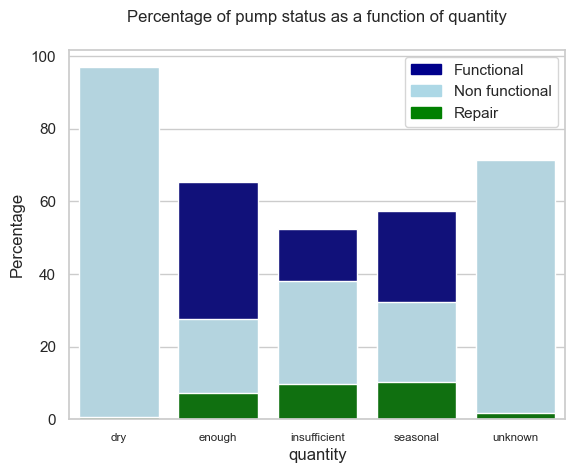

In [679]:
# # #region_code_status
# import matplotlib.patches as mpatches
# import seaborn as sns
# # bar chart 1 -> top bars (group of 'smoker=No')
# bar1 = sns.barplot(x="Xvalue",  y="FunctionalProportion", data=region_code_status, color='darkblue')
# # bar chart 2 -> bottom bars (group of 'smoker=Yes')
# bar2 = sns.barplot(x="Xvalue", y="NonFunctionalProportion", data=region_code_status, color='lightblue')
# bar3 = sns.barplot(x="Xvalue", y="RepairProportion", data=region_code_status, color='green')
# # add legend
# top_bar = mpatches.Patch(color='darkblue', label='Functional')
# middle_bar = mpatches.Patch(color='lightblue', label='Non functional')
# bottom_bar = mpatches.Patch(color='green', label='Repair')
# plt.legend(handles=[top_bar, middle_bar, bottom_bar])
# plt.xticks(fontsize = 'x-small', rotation=0)
# plt.title(f'Percentage of pump status as a function of {t_val}', pad=20)
# plt.xlabel(f'{t_val}')
# plt.ylabel("Percentage")
# # show the graph
# plt.show()


# # region_code_status

In [ ]:
# r_train.df['waterpoint_type'].value_counts()
# r_train.df['quan']

# 0: non functional
# 1: repair
# 2: functional

# final = r_train.df.loc[:,['status_group_encoding','quantity: enough', 'quantity: insufficient', 'quantity: seasonal', 'quantity: unknown', 'gps_height']]

# master = ['quantity: enough', 'quantity: insufficient', 'quantity: seasonal', 'quantity: unknown', 'gps_height']

# for mas in master:
#     num_pumps = final.groupby(f'{mas}').count()['status_group_encoding']
#     func = r_train.df.loc[r_train.df['status_group_encoding']==2].groupby(f'{mas}').count()['status_group_encoding']
#     nonfunc = r_train.df.loc[r_train.df['status_group_encoding']==0].groupby(f'{mas}').count()['status_group_encoding']
#     repair = r_train.df.loc[r_train.df['status_group_encoding']==1].groupby(f'{mas}').count()['status_group_encoding']
#     region_code_status = pd.concat([func, nonfunc, repair], axis=1)

#     region_code_status.columns = ['func', 'nonfunc', 'repair']
#     region_code_status['Xvalue'] = region_code_status.index

#     # bar chart 1 -> top bars (group of 'smoker=No')
#     bar1 = sns.barplot(x="Xvalue",  y="func", data=region_code_status, color='darkblue')
#     # bar chart 2 -> bottom bars (group of 'smoker=Yes')
#     bar2 = sns.barplot(x="Xvalue", y="nonfunc", data=region_code_status, color='lightblue')
#     bar3 = sns.barplot(x="Xvalue", y="repair", data=region_code_status, color='green')
#     # add legend
#     top_bar = mpatches.Patch(color='darkblue', label='Functional')
#     middle_bar = mpatches.Patch(color='lightblue', label='Non functional')
#     bottom_bar = mpatches.Patch(color='green', label='Repair')
#     plt.legend(handles=[top_bar, middle_bar, bottom_bar])
#     plt.xticks(fontsize = 'xx-small', rotation=90)
#     plt.title(f'Proportion of pump status as a function of {mas}', pad=20)
#     plt.xlabel(f'{mas}')
#     plt.ylabel("Percentage")
#     # show the graph
#     plt.show()


In [3]:
# non functional, functional needs repair, functional
# training_df.loc[ training_df['status_group'] == 'functional' ,['region_code']].sort_values(by='region_code', ascending =True).value_counts()
#f = training_df.groupby(['region_code'])['status_group'].count()
#.plot(legend = True, fontsize=8)

# r_train.df.loc[r_train.df['status_group_encoding']==2,['status_group_encoding']]

r_train.df

NameError: name 'r_train' is not defined

In [986]:
crazy = copy.deepcopy(training_df) # Take a copy of the df

crazy.drop(['date_recorded'], axis=1, inplace=True)

yT = crazy['status_group']
xT = crazy.loc[:, crazy.columns!='status_group']


In [155]:
# Start Random Forest Model: https://towardsdatascience.com/machine-learning-step-by-step-6fbde95c455a 
# Train-Test Split, 80-20% maybe?
# Try stratified kfold sampling
#Pointon=True 
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.80, random_state = 2, stratify=y)

#X_train, X_test, Y_train, Y_test = train_test_split(r_x, r_y, test_size=0.20, random_state=2, stratify=r_y)

#X_train and y_train are r_x and r_y respectively for braganza analysis


# # Dealing with the imbalanced classes
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import ConfusionMatrixDisplay
# from statistics import mean
# from sklearn.metrics import f1_score
# import inspect
# for sampler in [RandomUnderSampler, RandomOverSampler]:
#     sampler_type = inspect.getmembers(sampler, lambda a:not(inspect.isroutine(a)))[-1][-1]
#     # Either under- or over- sample the data
#     if sampler == RandomUnderSampler:
#         rs = sampler(replacement=False, random_state=0)
#     else:
#         rs = RandomOverSampler(random_state=0)
#     X_resampled, y_resampled = rs.fit_resample(r_x, r_y)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# # For cross validation, we do stratified kfold because it takes into
# # account class sizes and our dataset has class imbalance
# # Kfold sampling but maintaining the equal class balance
skf = StratifiedKFold(n_splits=15, shuffle=False)
for train_index, test_index in skf.split(r_x, r_y): #r_x, r_y
    X_train, X_test = r_x.iloc[train_index], r_x.iloc[test_index]
    Y_train, Y_test= r_y.iloc[train_index], r_y.iloc[test_index]

    rfc = RandomForestClassifier(random_state=2)
    rfc.fit(X_train, Y_train)

    y_pred = rfc.predict(X_test)
    
    new_score = accuracy_score(Y_test, y_pred, normalize=True)
    print(f'Accuracy {new_score}')

    # display('Baseline Random Forest recall score', recall_score(Y_test, y_pred, average = 'weighted'))
    # display('Baseline Random forest precision score',precision_score(Y_test, y_pred, average='weighted'))
    # Normalize=False if you want the number of correctly classified samples instead of percentage

display(rfc.score(X_train, Y_train))
display('Baseline Random forest accuracy score',accuracy_score(Y_test, y_pred, normalize=True))
display('Baseline Random forest F1 score',f1_score(Y_test, y_pred, average='weighted'))



Accuracy 0.7983257229832572
Accuracy 0.8107559614408929
Accuracy 0.8016235413495687
Accuracy 0.8033992897006595
Accuracy 0.7940131912734653
Accuracy 0.8003551496702181
Accuracy 0.8072044647387113
Accuracy 0.8003551496702181
Accuracy 0.7955352612886859
Accuracy 0.8074581430745814
Accuracy 0.7973110096397767
Accuracy 0.7983257229832572
Accuracy 0.797818366311517
Accuracy 0.7871098705912205
Accuracy 0.7977670641969044


0.9960497943356226

'Baseline Random forest accuracy score'

0.7977670641969044

'Baseline Random forest F1 score'

0.7938408068822962

In [156]:
y_pred = rfc.predict(X_test)

display('Baseline Random forest accuracy score',accuracy_score(Y_test, y_pred, normalize=True))


'Baseline Random forest accuracy score'

0.7977670641969044

In [214]:
# y_pred_prob = rfc.predict_proba(X_test)[::,1]
y_pred_prob = rfc.fit(X_train, Y_train).predict_proba(X_test)


# fpr1, tpr1, _a = roc_curve(Y_test, y_pred_prob)

In [219]:
y_pred_prob.shape

(3941, 3)

In [213]:
y_frame = pd.DataFrame(y_pred_prob)
y_frame

,0,1,2
0,0.00,0.02,0.98
1,0.01,0.00,0.99
2,0.00,0.97,0.03
3,0.00,0.59,0.41
4,0.00,0.05,0.95
...,...,...,...
3936,0.01,0.00,0.99
3937,0.02,0.00,0.98
3938,0.05,0.05,0.90
3939,0.00,0.01,0.99


In [185]:
y_test = copy.deepcopy(Y_test)
y_test = pd.DataFrame(y_test)
#y_test['status_group'] = Y_test[0].replace(0, "non functional")
y_test['status_group_encoding'].replace(0, "non functional", inplace=True)
y_test['status_group_encoding'].replace(1, "functional needs repair", inplace=True)
y_test['status_group_encoding'].replace(2, "functional", inplace=True)
#y_test.drop(columns=[0], inplace=True)
y_test.rename(columns={"status_group_encoding": "status_group"}, inplace=True)

y_train = copy.deepcopy(Y_train)
y_train = pd.DataFrame(y_train)
#y_train['status_group'] = Y_test[0].replace(0, "non functional")
y_train['status_group_encoding'].replace(0, "non functional", inplace=True)
y_train['status_group_encoding'].replace(1, "functional needs repair", inplace=True)
y_train['status_group_encoding'].replace(2, "functional", inplace=True)
#y_train.drop(columns=[0], inplace=True)
y_train.rename(columns={"status_group_encoding": "status_group"}, inplace=True)


In [230]:
y_train1 = y_train.status_group.values
y_test1 = y_test.status_group.values

In [231]:
y_test1

array(['functional needs repair', 'functional needs repair',
       'functional needs repair', ..., 'functional', 'functional',
       'functional'], dtype=object)

In [232]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
# binarize the output using 'ovr' or on vs rest scheme
# fpr1, tpr1, _a = metrics.roc_curve(Y_test, y_pred_prob)

label_binarizer = LabelBinarizer().fit(y_train1)
y_onehot_test = label_binarizer.transform(y_test1)
y_onehot_test.shape

(3941, 3)

In [233]:
label_binarizer.transform(['functional'])

array([[1, 0, 0]])

In [234]:
# target_names = training_df['status_group'].unique().tolist()
target_names = ['non functional', 'functional needs repair', 'functional']

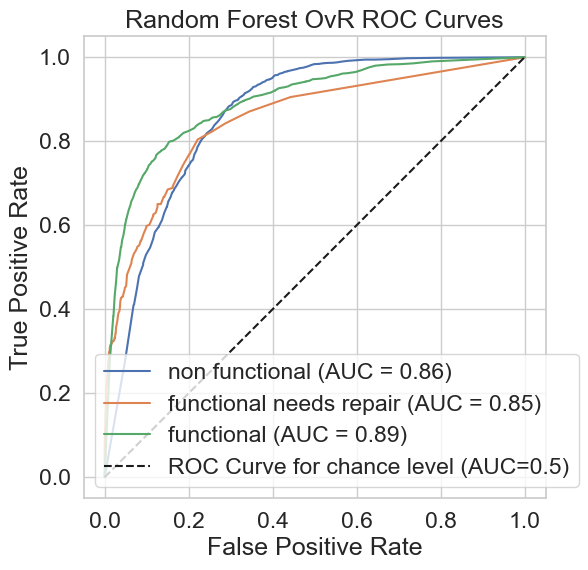

In [241]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6,6))

pumps = cycle(["non functional", "functional needs repair", "functional"])
for class_id, pump in zip(range(3), pumps):
    if pump == "non functional" or pump == "functional":
        RocCurveDisplay.from_predictions(y_onehot_test[:,class_id], -y_pred_prob[:,class_id], name=pump, ax=ax)
    else:
        RocCurveDisplay.from_predictions(y_onehot_test[:,class_id], y_pred_prob[:,class_id], name=pump, ax=ax)


plt.plot([0, 1], [0, 1], "k--", label="ROC Curve for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest OvR ROC Curves")
plt.legend()
plt.show()

In [12]:
## Weighted RFC

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold

# For cross validation, we do stratified kfold because it takes into
# account class sizes and our dataset has class imbalance
# Kfold sampling but maintaining the equal class balance

skf = StratifiedKFold(n_splits=15, shuffle=False)
for train_index, test_index in skf.split(r_x, r_y):
    X_train, X_test = r_x.iloc[train_index], r_x.iloc[test_index]
    Y_train, Y_test= r_y.iloc[train_index], r_y.iloc[test_index]

    weighted_rfc = RandomForestClassifier(random_state=2, class_weight='balanced')
    weighted_rfc.fit(X_train, Y_train)

    
    y_pred_weight = weighted_rfc.predict(X_test)



    # display('Weighted Random Forest recall score', recall_score(Y_test, y_pred_weight, average = 'weighted'))
    # display('Weighted Random forest precision score',precision_score(Y_test, y_pred_weight, average='weighted'))
    # Normalize=False if you want the number of correctly classified samples

display(weighted_rfc.score(X_train, Y_train))
display('Weighted Random forest accuracy score',accuracy_score(Y_test, y_pred_weight, normalize=True))
display('Weighted Random forest F1 score',f1_score(Y_test, y_pred_weight, average='weighted'))

0.9952525051189591

'Weighted Random forest accuracy score'

0.7949758944430347

'Weighted Random forest F1 score'

0.7911564315406838

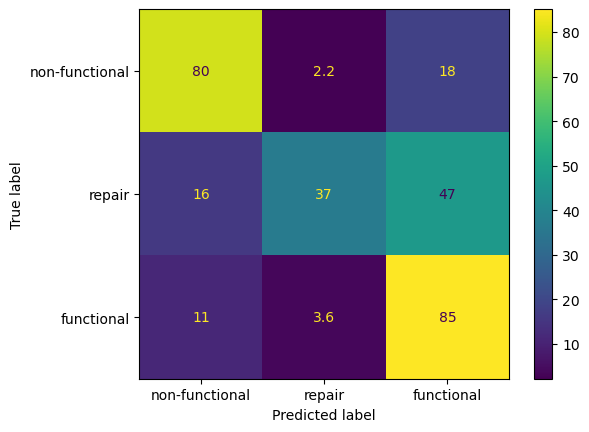

'Weighted Random forest accuracy score'

0.7949758944430347

'Weighted Random forest F1 score'

0.7911564315406838

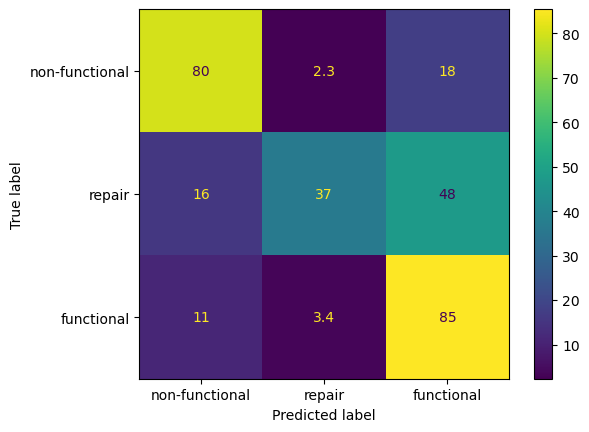

'Baseline Random forest accuracy score'

0.7977670641969044

'Baseline Random forest F1 score'

0.7938408068822962

In [18]:
y_pred_weight = weighted_rfc.predict(X_test)
#Weighted RF
weighted = confusion_matrix(Y_test, y_pred_weight,normalize='true')*100
disp = ConfusionMatrixDisplay(confusion_matrix = weighted, display_labels=['non-functional', 'repair', 'functional'])
disp.plot()
plt.show()
display('Weighted Random forest accuracy score',accuracy_score(Y_test, y_pred_weight, normalize=True))
display('Weighted Random forest F1 score',f1_score(Y_test, y_pred_weight, average='weighted'))


# 'Weighted Random forest accuracy score'0.7980208069018015
# 'Weighted Random forest F1 score'0.794300044367066

y_pred = rfc.predict(X_test)
baseline = confusion_matrix(Y_test, y_pred, normalize='true')*100
disp = ConfusionMatrixDisplay(confusion_matrix = baseline, display_labels=['non-functional', 'repair', 'functional'])
disp.plot()
plt.show()

# display('Baseline Random Forest recall score', recall_score(Y_test, y_pred, average = 'weighted'))
# display('Baseline Random forest precision score',precision_score(Y_test, y_pred, average='weighted'))
# # Normalize=False if you want the number of correctly classified samples instead of percentage
display('Baseline Random forest accuracy score',accuracy_score(Y_test, y_pred, normalize=True))
display('Baseline Random forest F1 score',f1_score(Y_test, y_pred, average='weighted'))


In [1238]:
# Predict test data with rfc
def decode_dep_var(model_predictions):
    # Do we want to do these?
    model_predictions = pd.DataFrame(model_predictions)
    model_predictions['status_group'] = model_predictions[0].replace(0, "non functional")
    model_predictions['status_group'].replace(1, "functional needs repair", inplace=True)
    model_predictions['status_group'].replace(2, "functional", inplace=True)
    model_predictions.drop(columns=[0], inplace=True)
    return model_predictions

def concat_id_and_predictions(test_object, predictions):
    prediction_output = pd.DataFrame()
    prediction_output['id'] = test_object.ids
    prediction_output['status_group'] = predictions
    return prediction_output


rfcModel = rfc.predict(r_test.df)
#rfcPrediction

predicted_result = decode_dep_var(rfcModel)
predicted_result_join = concat_id_and_predictions(r_test, predicted_result)
predicted_result_join.to_csv("basicRFv5.csv", index = False)
predicted_result_join

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [153]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

n_estimators = [700]
max_features = ['sqrt']
max_depth = [12,13]
min_samples_split = [24,43]
min_samples_leaf = [19,33]
bootstrap = [False]

param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
param_grid={}

# gs = GridSearchCV(rfc1, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(r_x_pca, r_y)
# rfc2 = gs.best_estimator_
# gs.best_params_ 


# params = {
#     'l1_ratio': [1],
#     'C': [(1/5.2), 0.1, 0.05, 0.01, 0.001], # alpha>=5.1 for KT conditions to hold, so C<=0.196
# } #

# We will use a Logistic Regression model, but using Sklearn rather than statsmodels to use the GridSearchCV function
#lr_model = linear_model.LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, penalty='elasticnet')

# CV setup for the inner and outer loops
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Standard, non_nested parameter search and scoring
# clf = GridSearchCV(estimator=lr_model, param_grid=params, cv=outer_cv, scoring='f1_weighted')
rfc = RandomForestClassifier(random_state=2)
clf = GridSearchCV(rfc, param_grid, cv = outer_cv, verbose = 1, n_jobs=-1)
clf.fit(r_x, r_y)
print(f'Non-nested: {clf.best_estimator_} with a CV score of {clf.best_score_}.')

# Nested CV with parameter optimization to find the generalisation error
# clf = GridSearchCV(estimator=lr_model, param_grid=params, cv=inner_cv)
clf = GridSearchCV(rfc, param_grid, cv = inner_cv, verbose = 1, n_jobs=-1)
nested_score = cross_val_score(clf, X=r_x, y=r_y, cv=outer_cv, scoring='f1_weighted')
nested_accuracy = cross_val_score(clf, X=r_x, y=r_y, cv=outer_cv, scoring='accuracy')
print(f'The generalisation error (f1_weighted) is: {nested_score.mean():.4f} ± {nested_score.std():.4f}: [{nested_score.mean()-1.96*nested_score.std():.4f}, {nested_score.mean()+1.96*nested_score.std():.4f}]')
print(f'The generalisation error (accuracy) is: {nested_accuracy.mean():.4f} ± {nested_accuracy.std():.4f}: [{nested_accuracy.mean()-1.96*nested_accuracy.std():.4f}, {nested_accuracy.mean()+1.96*nested_accuracy.std():.4f}]')

# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Non-nested: RandomForestClassifier(bootstrap=False, max_depth=13, min_samples_leaf=19,
#                        min_samples_split=43, n_estimators=700, random_state=2) with a CV score of 0.7655424643947527.
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# The generalisation error (f1_weighted) is: 0.7411 ± 0.0024: [0.7364, 0.7458]
# The generalisation error (accuracy) is: 0.7653 ± 0.0020: [0.7613, 0.7692]

# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Non-nested: RandomForestClassifier(random_state=2) with a CV score of 0.7977776247484223.
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# The generalisation error (f1_weighted) is: 0.7938 ± 0.0042: [0.7855, 0.8021]
# The generalisation error (accuracy) is: 0.7978 ± 0.0042: [0.7896, 0.8060]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Non-nested: RandomForestClassifier(random_state=2) with a CV score of 0.7977776247484223.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
The generalisation error (f1_weighted) is: 0.7938 ± 0.0042: [0.7855, 0.8021]
The generalisation error (accuracy) is: 0.7978 ± 0.0042: [0.7896, 0.8060]


In [245]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred1 = rfc.predict_proba(X_test)
#y_pred_weight1 = weighted_rfc.predict_proba(X_test)


roc_auc = roc_auc_score(Y_test, y_pred1, average='macro', multi_class='ovr')
roc_auc


0.8884873508320853

In [99]:
ypred2 = rfc.predict_proba(X_test)
roc_auc = roc_auc_score(Y_test, y_pred2, average='weighted', multi_class='ovr')
roc_auc

NameError: name 'y_pred2' is not defined

In [112]:
# def decode_dep_var(y_testing):
#     # Do we want to do these?
#     y_testing = pd.DataFrame(y_testing)
#     y_testing['status_group'] = y_testing[0].replace(0, "non functional")
#     y_testing['status_group'].replace(1, "functional needs repair", inplace=True)
#     y_testing['status_group'].replace(2, "functional", inplace=True)
#     y_testing.drop(columns=[0], inplace=True)
#     return y_testing

y_testing = copy.deepcopy(r_y)
y_testing = pd.DataFrame(y_testing)
#y_testing['status_group'] = Y_test[0].replace(0, "non functional")
y_testing['status_group_encoding'].replace(0, "Non functional", inplace=True)
y_testing['status_group_encoding'].replace(1, "Functional needs repair", inplace=True)
y_testing['status_group_encoding'].replace(2, "Functional", inplace=True)
#y_testing.drop(columns=[0], inplace=True)
y_testing.rename(columns={"status_group_encoding": "status_group"}, inplace=True)

y_testing

,status_group
0,Functional
1,Functional
2,Functional
3,Non functional
4,Functional
...,...
59123,Functional
59124,Functional
59125,Functional
59126,Functional


In [145]:
y_pred = rfc.predict(r_x)
y_pred_probs = pd.DataFrame(rfc.predict_proba(r_x))
#y_pred4 = pd.DataFrame(y_pred1)

In [146]:
display('accuracy score',accuracy_score(r_y, y_pred))


'accuracy score'

0.9828338519821405

In [142]:
pd.DataFrame(y_pred).value_counts()

2    32125
0    22692
1     4311
dtype: int64

       0  1  2
0      0  0  1
1      0  0  1
2      0  0  1
3      1  0  0
4      0  0  1
...   .. .. ..
59123  0  0  1
59124  0  0  1
59125  0  0  1
59126  0  0  1
59127  0  0  1

[59128 rows x 3 columns]


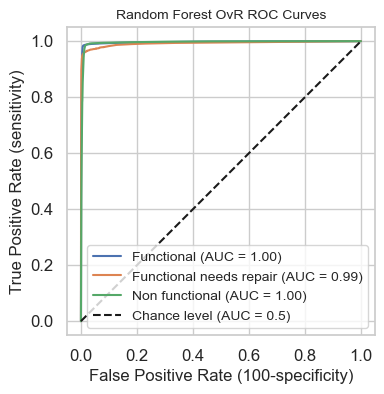

In [147]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer


label_binarizer = LabelBinarizer().fit(r_y)
y_onehot_train = pd.DataFrame(label_binarizer.transform(r_y))
print(y_onehot_train)
fig, ax = plt.subplots(figsize=(4, 4))
class_labels = ['Functional', 'Functional needs repair', 'Non functional']
for class_id, class_label in zip(range(3), class_labels):
    RocCurveDisplay.from_predictions(
        y_onehot_train[class_id],
        y_pred_probs[class_id],
        name=class_label,
        ax=ax,
    )
FONT_SIZE = 12
ax.title.set_fontsize(FONT_SIZE)
ax.xaxis.label.set_fontsize(FONT_SIZE)
ax.yaxis.label.set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
# ax.tick_params(axis='both', which='minor', labelsize=8)
map(lambda p: p.set_fontsize(FONT_SIZE), ax.get_xticklabels())
map(lambda p: p.set_fontsize(FONT_SIZE), ax.get_yticklabels())
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate (100-specificity)")
plt.ylabel("True Positive Rate (sensitivity)")
plt.title("Random Forest OvR ROC Curves", fontsize=10)
plt.legend(prop={'size': FONT_SIZE-2})
plt.savefig(f'Braganza_Predictions/RF_roc_curve.png', dpi=1200, bbox_inches="tight")

In [126]:
# y_pred4.iloc[:,0]
pd.DataFrame(y_pred_probs)

,0,1,2
0,0.00,0.11,0.89
1,0.12,0.03,0.85
2,0.00,0.00,1.00
3,1.00,0.00,0.00
4,0.01,0.11,0.88
...,...,...,...
59123,0.01,0.00,0.99
59124,0.02,0.00,0.98
59125,0.05,0.05,0.90
59126,0.00,0.01,0.99


In [96]:
y_pred3 = rfc.predict_proba(X_test)
# RocCurveDisplay.from_estimator( rfc, X_test, Y_test)

# RocCurveDisplay.from_predictions(
#     y_onehot_train[class_id],
#     y_pred3[class_id],
#     name=class_label,
#     ax=ax,
# )

y_pred4 = pd.DataFrame(y_pred3)

from sklearn.metrics import roc_curve, roc_auc_score

#y_pred1 = rfc.predict_proba(X_test)
#y_pred_weight1 = weighted_rfc.predict_proba(X_test)


roc_auc = roc_auc_score(Y_test, y_pred3, average='weighted', multi_class='ovo')
roc_auc


0.8793369902216763

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

# X_train1, X_test1, Y_train1, Y_test1 = train_test_split(r_x, r_y, test_size=0.20, random_state=2, stratify=r_y)

# brfc = BalancedRandomForestClassifier(n_estimators=500,random_state=2)
# brfc.fit(X_train1,Y_train1)
# display(brfc.score(X_train1, Y_train1))

# y_brfc = brfc.predict(X_test1)


skf = StratifiedKFold(n_splits=15, shuffle=False)
for train_index, test_index in skf.split(r_x, r_y):
    X_train, X_test = r_x.iloc[train_index], r_x.iloc[test_index]
    Y_train, Y_test= r_y.iloc[train_index], r_y.iloc[test_index]

    brfc = BalancedRandomForestClassifier(n_estimators=100,random_state=2)
    brfc.fit(X_train,Y_train)
    display(brfc.score(X_train, Y_train))

    y_brfc = brfc.predict(X_test)

    # display('Weighted Random Forest recall score', recall_score(Y_test, y_pred_weight, average = 'weighted'))
    # display('Weighted Random forest precision score',precision_score(Y_test, y_pred_weight, average='weighted'))
    # Normalize=False if you want the number of correctly classified samples
    display('BRFC Random forest accuracy score',accuracy_score(Y_test, y_pred_weight, normalize=True))
    display('BRFC Random forest F1 score',f1_score(Y_test, y_pred_weight, average='weighted'))

In [839]:
# Baseline Random Forest Model 
# Pointon True: 0.8855039350088855
# Braganza True: 0.9999152973064543
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

# random_state decides which features to select for a split
# rfc = RandomForestClassifier(random_state=2)
# rfc.fit(X_train, Y_train)
# display(rfc.score(X_train, Y_train))



0.9968855218855219

In [1171]:
# #0:1,1:3,2:1
# weighted_rfc = RandomForestClassifier(random_state=2, class_weight={0:0.38,1:0.072,2:0.543})
# weighted_rfc.fit(X_train, Y_train)
# display(weighted_rfc.score(X_train, Y_train))

rfc = RandomForestClassifier(random_state=2)
rfc.fit(X_train, Y_train)
display(rfc.score(X_train, Y_train))

0.9437920875420875

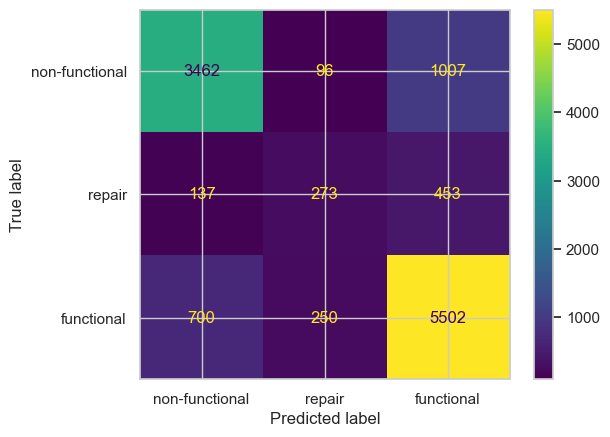

'Baseline Random forest accuracy score'

0.7775252525252525

'Baseline Random forest F1 score'

0.7724455125215145

In [1172]:
#y_pred_weight = weighted_rfc.predict(X_test)

#y_brfc = brfc.predict(X_test)


#BASELINE MODEL
#display(conf_matrix_baseline)
y_pred = rfc.predict(X_test)
baseline = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = baseline, display_labels=['non-functional', 'repair', 'functional'])
disp.plot()
plt.show()

# display('Baseline Random Forest recall score', recall_score(Y_test, y_pred, average = 'weighted'))
# display('Baseline Random forest precision score',precision_score(Y_test, y_pred, average='weighted'))
# # Normalize=False if you want the number of correctly classified samples instead of percentage
display('Baseline Random forest accuracy score',accuracy_score(Y_test, y_pred, normalize=True))
display('Baseline Random forest F1 score',f1_score(Y_test, y_pred, average='weighted'))

#y_pred_weight = weighted_rfc.predict(X_test)
# #Weighted RF
# weighted = confusion_matrix(Y_test, y_pred_weight)
# disp = ConfusionMatrixDisplay(confusion_matrix = weighted, display_labels=['non-functional', 'repair', 'functional'])
# disp.plot()
# plt.show()
# display('Weighted Random forest accuracy score',accuracy_score(Y_test, y_pred_weight, normalize=True))
# display('Weighted Random forest F1 score',f1_score(Y_test, y_pred_weight, average='weighted'))


# display('Weighted Random Forest recall score', recall_score(Y_test, y_pred_weight, average = 'weighted'))
# display('Weighted Random forest precision score',precision_score(Y_test, y_pred_weight, average='weighted'))

# # Normalize=False if you want the number of correctly classified samples

# 'Baseline Random forest precision score'0.7920992897259569
# 'Baseline Random forest accuracy score'0.7973905723905724
# 'Baseline Random forest F1 score'0.7937540187668343

# BRFC Balanced Random Forest Classifier
# #Weighted RF
# balanced = confusion_matrix(Y_test, y_brfc)
# disp = ConfusionMatrixDisplay(confusion_matrix = balanced, display_labels=['non-functional', 'repair', 'functional'])
# disp.plot()
# plt.show()

# display('BRFC Random forest accuracy score',accuracy_score(Y_test, y_brfc, normalize=True))
# display('BRFC Random forest F1 score',f1_score(Y_test, y_brfc, average='weighted'))


#3 ratio
# 'Weighted Random forest precision score'0.7926079099993723
# 'Weighted Random forest accuracy score'0.798063973063973
# 'Weighted Random forest F1 score'0.7942680201541822

In [1157]:
X_test

,gps_height,longitude,latitude,quantity,age
17318,168,38.362978,-6.633266,0,7.000000
41544,343,38.811686,-10.615871,0,38.000000
17763,297,36.628393,-8.407331,2,19.000000
27042,0,33.825325,-9.210901,0,12.072388
11764,852,36.079413,-10.591042,1,16.000000
...,...,...,...,...,...
12744,1681,34.783304,-8.956569,0,3.000000
42035,320,38.422874,-5.213782,1,20.000000
43998,1758,35.211867,-4.144332,0,20.000000
19295,0,0.000000,0.000000,0,10.791240


In [1173]:
# from sklearn.datasets import make_classification
# from sklearn.metrics import ConfusionMatrixDisplay

# # 0 is non functional
# # 1 is functional and needs repair
# # 2 is functional
# fig=ConfusionMatrixDisplay.from_estimator(rfc, X_test, Y_test)
# plt.show()
from sklearn.metrics import roc_curve, roc_auc_score

y_pred1 = rfc.predict_proba(X_test)
#y_pred_weight1 = weighted_rfc.predict_proba(X_test)


roc_auc = roc_auc_score(Y_test, y_pred1, average='weighted', multi_class='ovo')
roc_auc

# roc_auc for quantity and gps_height: 0.6542802615978801

0.8645788982294613

In [ ]:
# GPS HEIGHT and QUANTITY
#'Baseline Random forest accuracy score'0.6368686868686869' 
# Baseline Random forest F1 score'0.6007541900246159
# 'Weighted Random forest accuracy score'0.6196969696969697
# 'Weighted Random forest F1 score'0.5970527945866033
# roc_auc for quantity and gps_height: 0.6542802615978801

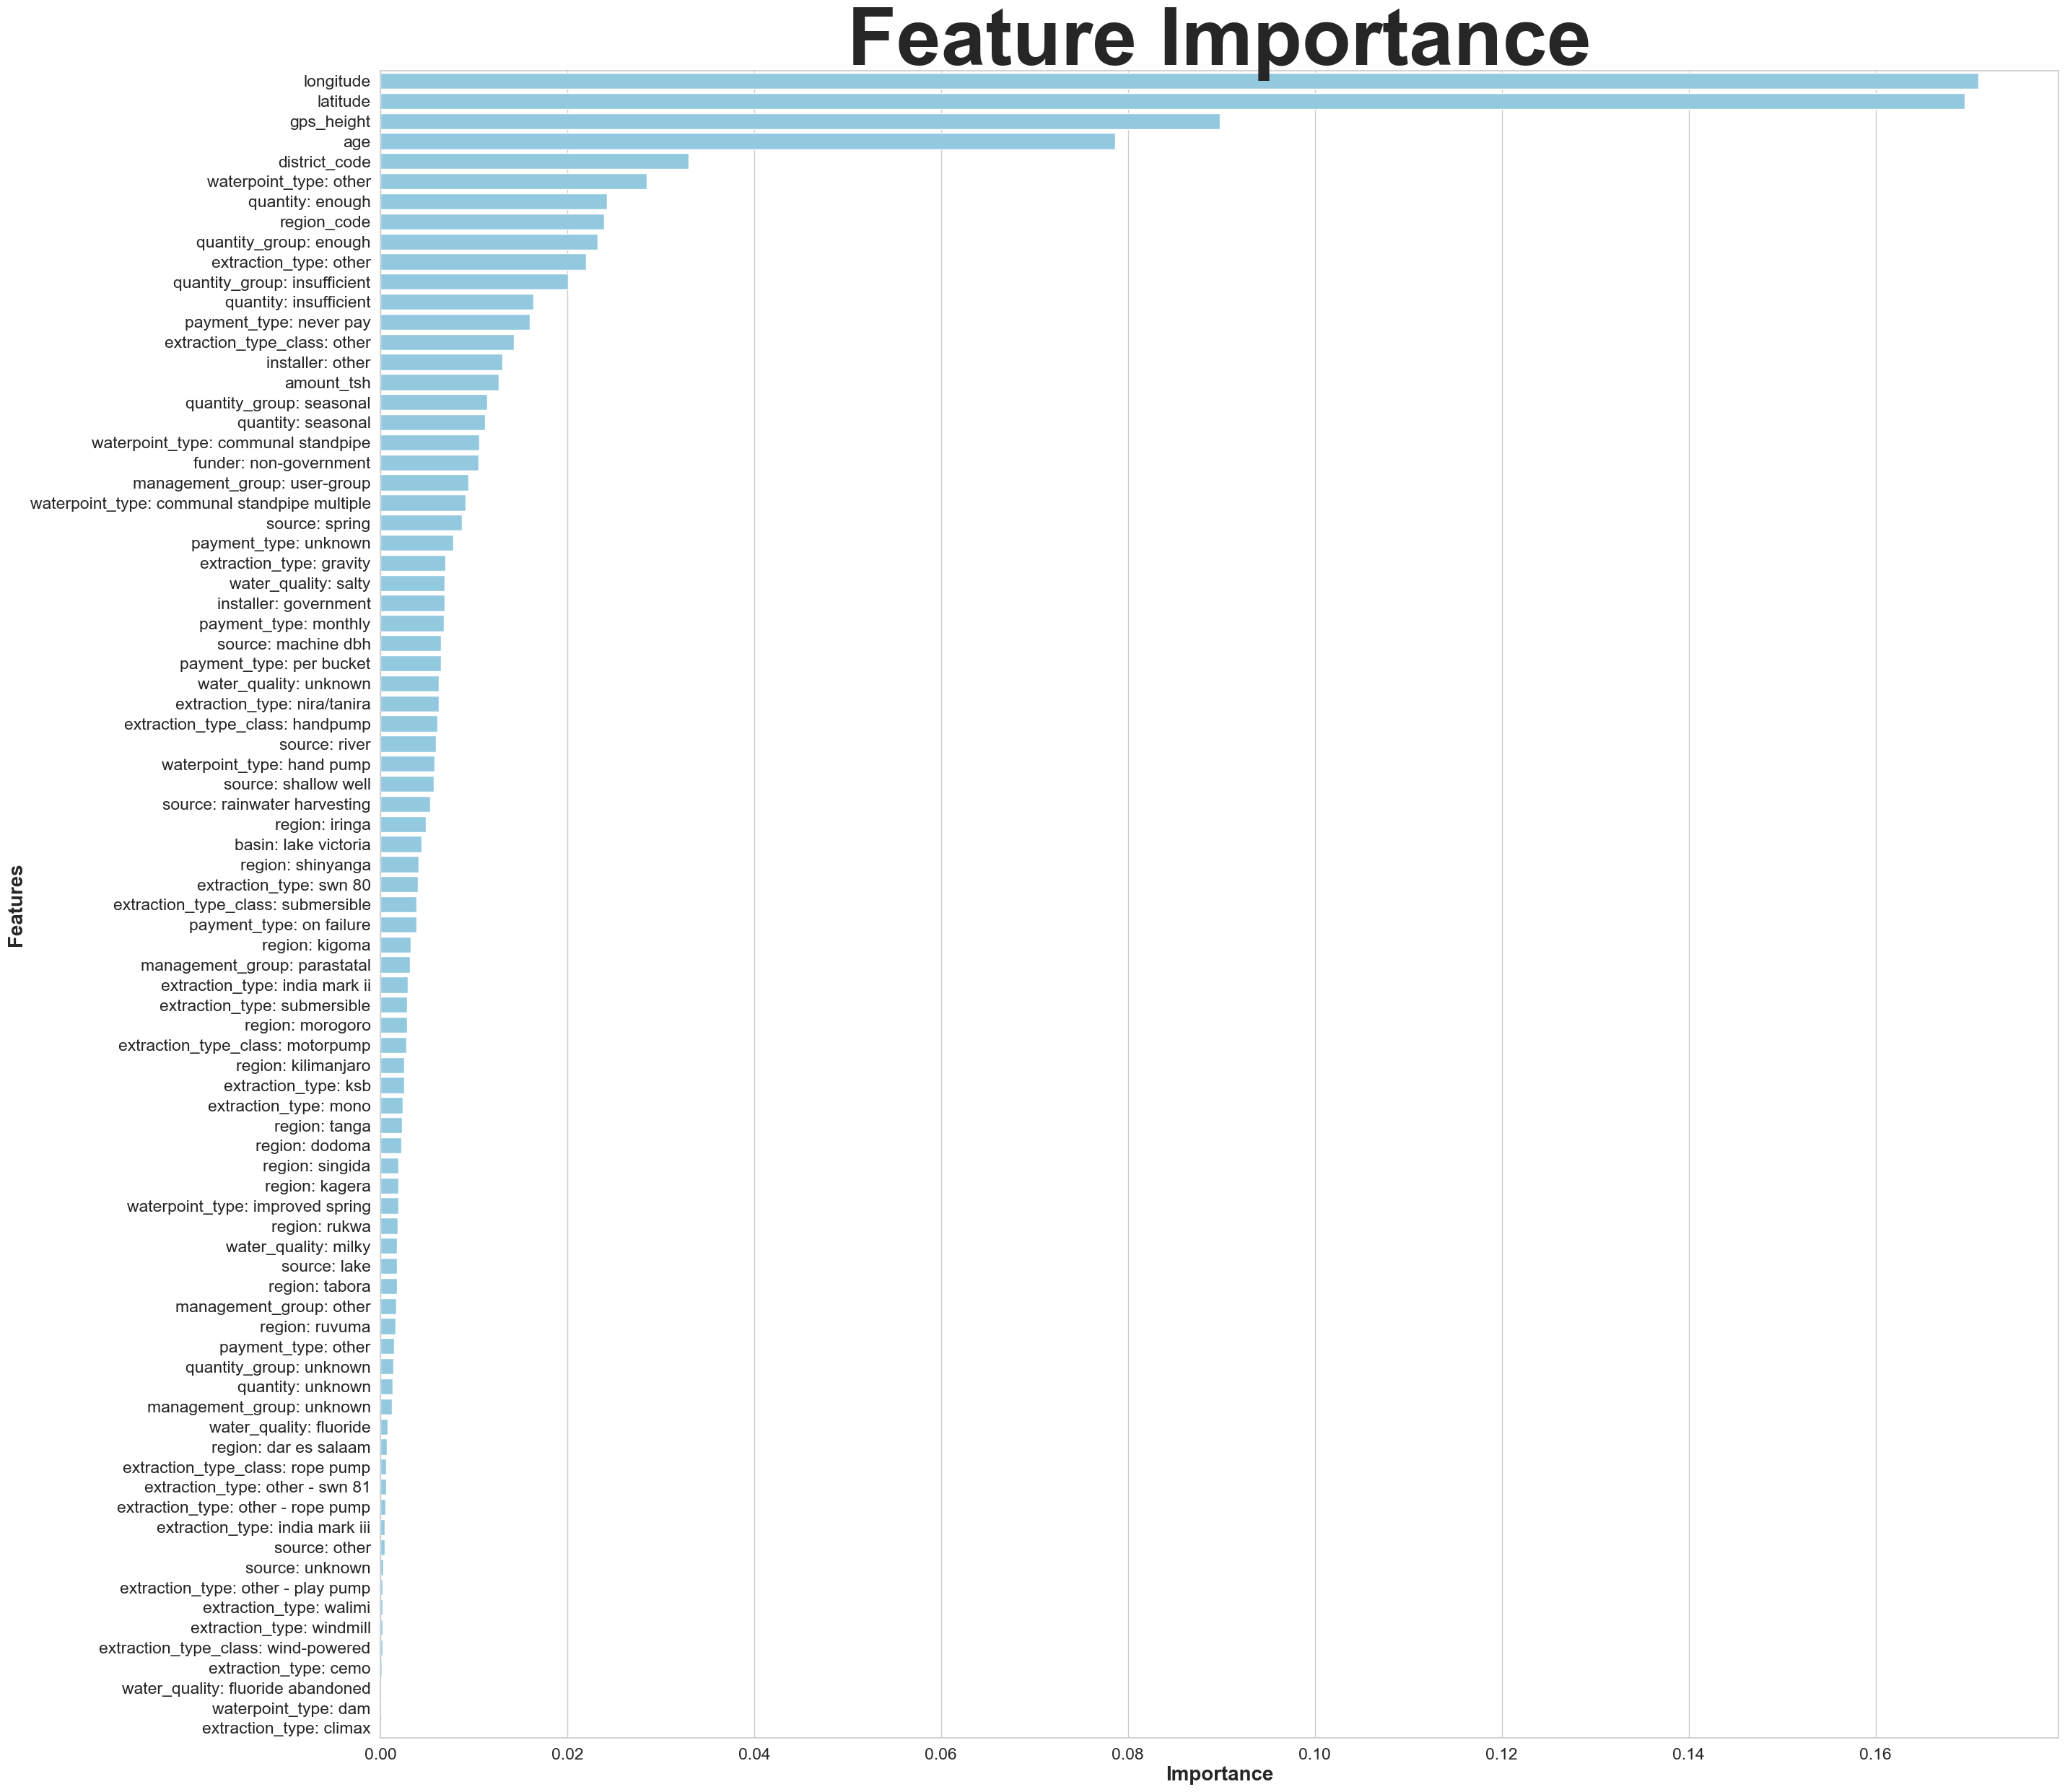

None

,Features,Gini-Importance
0,longitude,0.171007
1,latitude,0.169501
2,gps_height,0.089825
3,age,0.078611
4,district_code,0.033019
...,...,...
78,extraction_type_class: wind-powered,0.000234
79,extraction_type: cemo,0.000145
80,water_quality: fluoride abandoned,0.000096
81,waterpoint_type: dam,0.000061


In [149]:
# Show us which features are most important to the Random forest model
# Calls feature_importances_ method
u = 0
feats = {}
for feature, importance in zip(r_x.columns,rfc.feature_importances_):
    feats[feature] = importance
    u+=4
    # if u == 20:
    #     break
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.5)
fig, ax = plt.subplots()
fig.set_size_inches(30,30)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=20, weight = 'bold')
plt.ylabel('Features', fontsize=20, weight = 'bold')
plt.title('Feature Importance', fontsize=80, weight = 'bold')

display(plt.show())
display(importances)

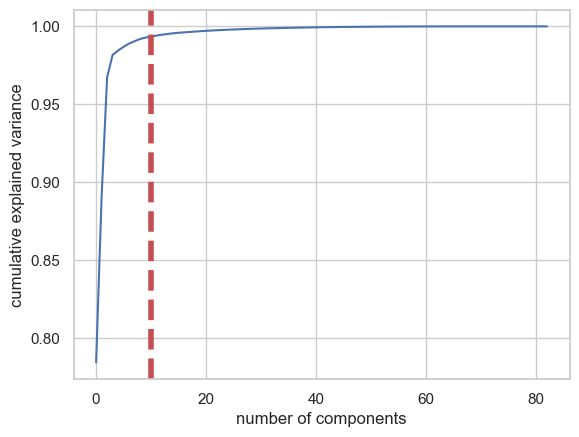

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.784562,0.784562
1,0.891017,0.106455
2,0.967375,0.076357
3,0.981693,0.014319
4,0.984495,0.002802
5,0.986904,0.002409
6,0.988983,0.002079
7,0.990490,0.001507
8,0.991927,0.001437
9,0.992808,0.000881


In [252]:
# PCA Random Forest

#55 components or columns in braganza True set and 51 in pointon True set
pca_test = PCA(n_components =83)
pca_test.fit(X_train)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)

pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr 
pca_df['Explained Variance Ratio'] = evr 
display(pca_df.head(30))


In [253]:
# Since PCA showed 30 components cover 95% of variance can discard 21 other components

# Braganza: do 16 components
pca = PCA(n_components=10)
pca.fit(X_train)
#pca.fit(r_test.df)
# Dimensionality reduction
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# Based on r_test.df
#test_pca = pca.transform(test.df)
test_pca = pca.transform(r_test.df)

In [255]:
# View weight for each PCA component
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x+1))

pca_test_df = pd.DataFrame(pca_test.components_, columns=X_train.columns, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,PCA Component 10
amount_tsh,-0.000619,0.003506,-0.012997,0.021465,0.402296,0.479501,0.733314,-0.062692,0.053230,-0.091205
gps_height,-0.010038,0.009711,-0.026924,0.003528,0.671618,-0.104887,-0.340833,0.067620,0.565825,0.135405
longitude,0.024364,0.635139,-0.736321,-0.226517,-0.034137,0.005354,0.003055,-0.010885,0.008416,-0.018345
latitude,-0.036927,-0.126309,0.185202,-0.965090,0.052902,0.008332,0.005364,-0.018054,-0.017139,0.002708
region_code,0.917613,-0.318613,-0.233849,-0.036846,0.011969,-0.001062,-0.004997,0.007867,-0.005194,-0.006271
...,...,...,...,...,...,...,...,...,...,...
extraction_type: other - swn 81,-0.000034,-0.000038,-0.000243,0.000979,-0.002185,0.001353,-0.000327,-0.001130,0.005230,0.002713
extraction_type: submersible,0.000966,0.002382,-0.005017,-0.002656,-0.006110,0.030367,0.017601,0.003846,-0.062396,0.245649
extraction_type: swn 80,-0.000655,-0.001137,0.000354,0.007462,-0.044232,0.019015,0.019886,-0.015612,0.089273,-0.028127
extraction_type: walimi,-0.000001,-0.000255,0.000278,0.000030,-0.000380,0.000322,-0.000084,-0.000231,0.000129,-0.000117


In [256]:
# Fit Baseline Random Forest Model after PCA

pcaRFC = RandomForestClassifier(random_state=2)
pcaRFC.fit(X_train_pca, Y_train)

display(pcaRFC.score(X_train_pca, Y_train)) 

#Pre PCA model accurancy was 0.8855039350088855

0.9960679145450921

In [261]:
# Hyperparameter tuning using RandomSearchCV

# "verbose" hyperparameter gives you updates as the model runs
# "n_jobs" hyperparameter tells how many cores of your processor are used to run model
# n_jobs = -1 will run the model fastest as it uses all computer cores
# n_estimators: the number of “trees” in our Random Forest
# max_features: the number of features at each split
# max_depth: the max number of “splits” each tree can have.
# min_samples_split: the minimum number of observations required before a node of a tree can split itself
# min_samples_leaf: the minimum number of observations required at each leaf at the ends of each tree
# bootstrap: whether to use bootstrapping or not to provide data to each tree in the Random Forest. (Bootstrapping is a random sampling from the dataset with replacement.)

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rs = RandomizedSearchCV(pcaRFC, param_dist, n_iter = 10, cv = 3, verbose = 1, n_jobs = -1, random_state=2)

rs.fit(X_train_pca, Y_train)
rs.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 100,
 'min_samples_split': 12,
 'min_samples_leaf': 39,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': True}

In [262]:
# Dataframe of RandomSearchCV Results
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'std_test_score'], axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,100,12,39,sqrt,12,True,0.746716,1
1,900,50,44,log2,10,True,0.734557,2
2,600,50,12,log2,8,False,0.725316,3
3,700,34,28,log2,8,False,0.722580,4
4,700,50,34,log2,8,True,0.717524,5
5,800,18,34,log2,4,True,0.657637,6
6,400,23,18,sqrt,3,False,0.638991,7
7,800,34,44,sqrt,2,False,0.629677,8
8,100,44,12,log2,1,False,0.577926,9
9,1000,7,2,sqrt,1,False,0.577872,10


In [263]:
rs_df['mean_test_score'].min()

0.5778715746356968

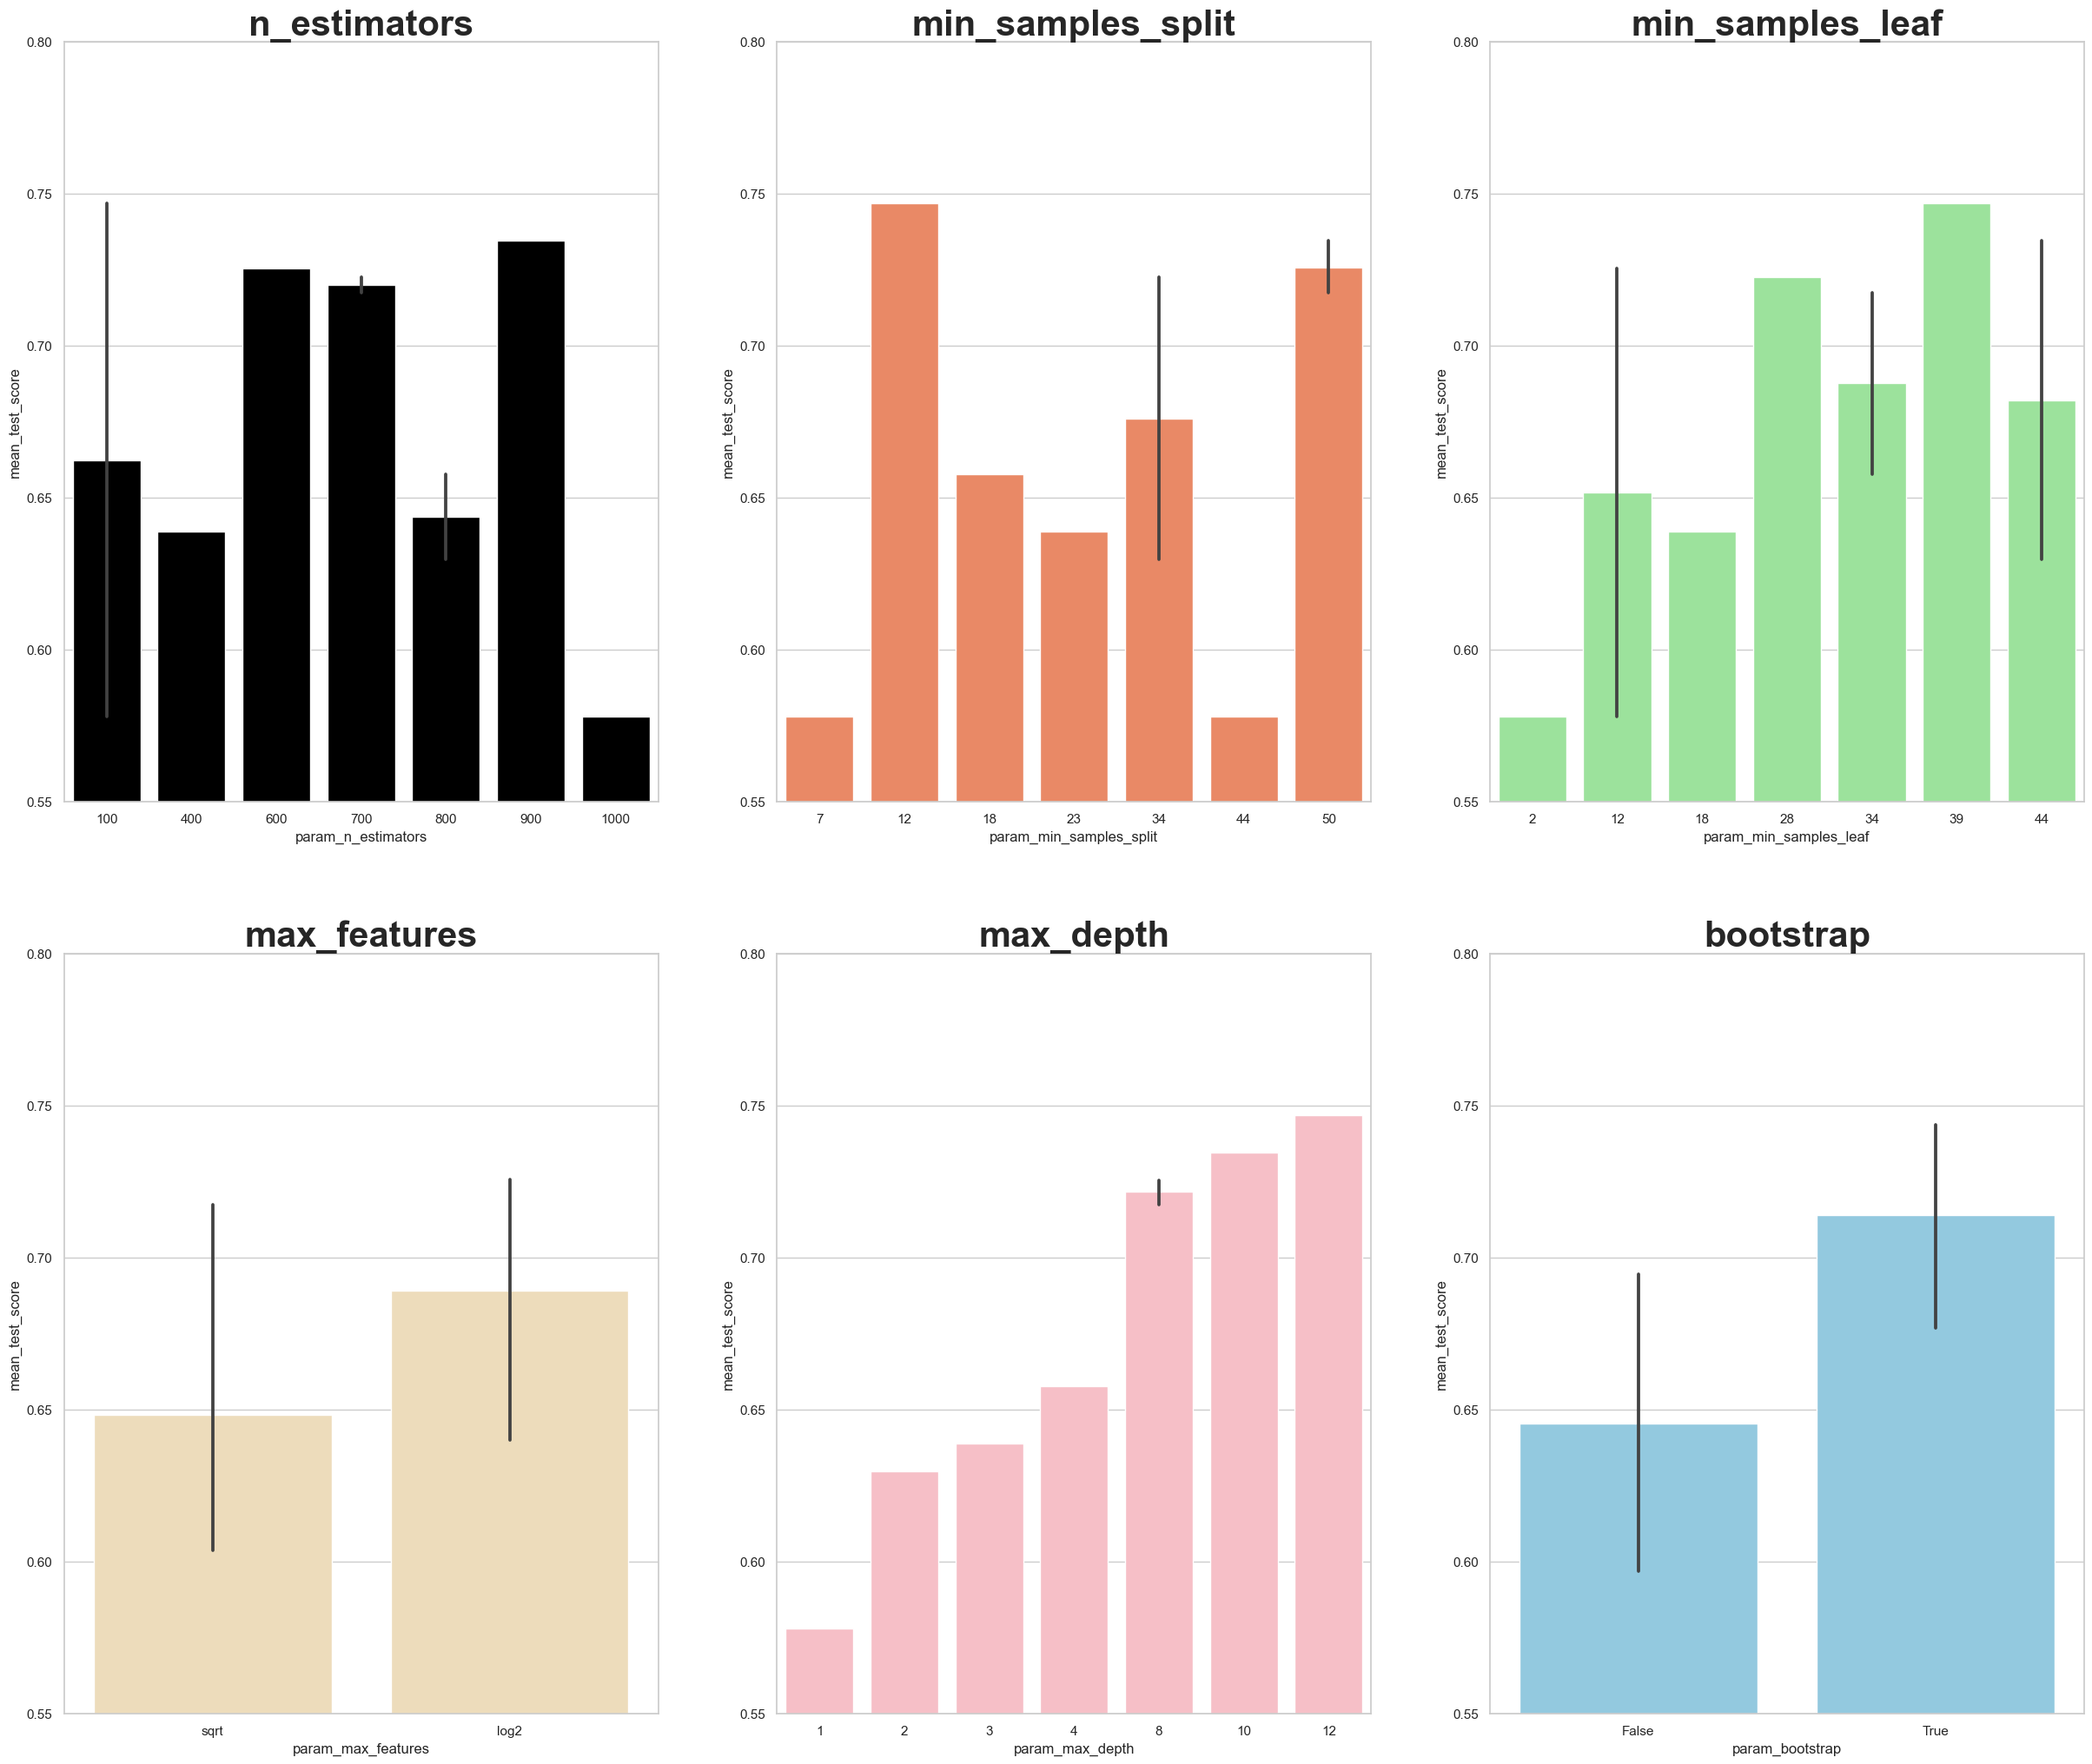

In [264]:
# Barplots of RandomSearchCV Results

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig.set_size_inches(30,25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='black')
axs[0,0].set_ylim([.55,.80])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.55,.80])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.55,.80])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.55,.80])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.55,.80])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap', y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.55,.80])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

In [266]:
# Hyperparameter Tuning with GridSearchCV
# use same hyperparameter but perform more exhaustive search 
# every single combination of hyperparameter values is tried -> computationally expensive than RandomSearchCV
# So we perform GridSearchCV after using RandomSearchCV

# {'n_estimators': 100,
#  'min_samples_split': 12,
#  'min_samples_leaf': 39,
#  'max_features': 'sqrt',
#  'max_depth': 12,
#  'bootstrap': True}

from sklearn.model_selection import GridSearchCV

n_estimators = [100]
max_features = ['sqrt']
max_depth = [12]
min_samples_split = [12]
min_samples_leaf = [39]
bootstrap = [True]

param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

gs = GridSearchCV(pcaRFC, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_pca, Y_train)
rfc2 = gs.best_estimator_
gs.best_params_ 

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 39,
 'min_samples_split': 12,
 'n_estimators': 100}

In [269]:
# Pause for evluation of model on test data

y_pred_gs = gs.best_estimator_.predict(X_test_pca)

In [270]:
# Evaluate Performance of 3 Models on Test Data
# rfc - Baseline Random Forest
# rfc1 - Baseline Random Forest with PCA Reduced Dimensionality
# rfc2 - Baseline Random Forest with PCA Reduced Dimensionality and Hyperparameter Tuning

y_pred = rfc.predict(X_test)
y_pred_pca = pcaRFC.predict(X_test_pca)
# y_pred_gs = gs.best_estimator_.predict(X_test_pca)
# y_pred_gs1 = gs.predict(X_test_pca)
# or rfc2.predict(X_test_pca)

# y_pred_weight = weighted_rfc.predict(X_test)

In [267]:
display(gs.score(X_train_pca, Y_train)) 


0.7746933154547266

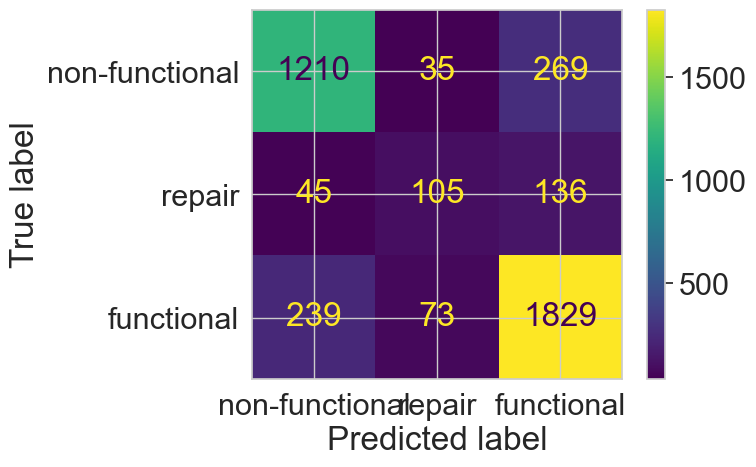

'Baseline Random Forest recall score'

0.7977670641969044

'Baseline Random forest precision score'

0.7916883871857447

'Baseline Random forest accuracy score'

0.7977670641969044

'Baseline Random forest F1 score'

0.7938408068822962

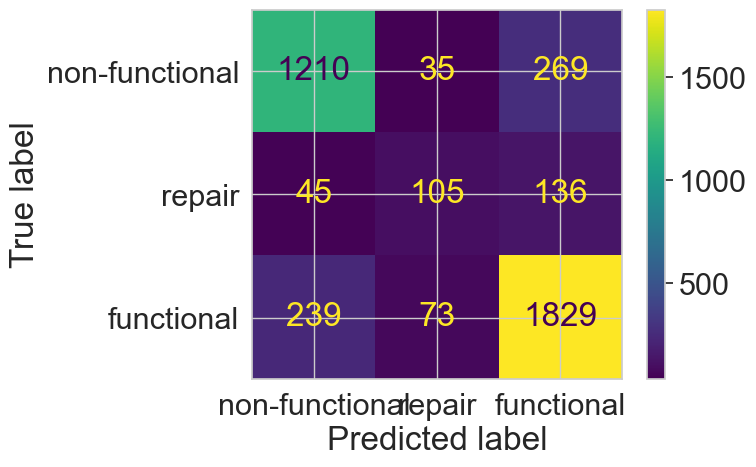

'Baseline Random Forest with PCA recall score'

0.7906622684597818

'Baseline Random Forest with PCA recall score'

0.7843751538240253

'Baseline Random Forest with PCA recall score'

0.7906622684597818

'Baseline Random Forest with F1 score'

0.7864934382183701

,predicted 0,predicted 1,predicted 2
actual 0,1073,2,439
actual 1,60,31,195
actual 2,250,10,1881


'Hyperparameter Tuned Random Forest with PCA Reduced Dimensionality recall score'

0.7574219741182441

'Hyperparameter Tuned Random Forest with PCA Reduced Dimensionality recall score'

0.7566868967572957

'Hyperparameter Tuned Random Forest with PCA Reduced Dimensionality recall score'

0.7574219741182441

'Hyperparameter Tuned Random Forest with PCA Reduced Dimensionality F1 score'

0.7372044602064003

,predicted 0,predicted 1,predicted 2
actual 0,1073,2,439
actual 1,60,31,195
actual 2,250,10,1881


In [271]:
# Confusion matrices for each model
# 0 is non functional
# 1 is functional and needs repair
# 2 is functional



conf_matrix_baseline = pd.DataFrame(confusion_matrix(Y_test, y_pred), index = ['actual non-functional', 'actual repair', 'actual functional'], columns = ['predicted non-functional', 'predicted repair', 'predicted functional'])

conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(Y_test, y_pred_pca), index = ['actual non-functional', 'actual repair', 'actual functional'], columns = ['predicted non-functional', 'predicted repair', 'predicted functional'])

conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(Y_test, y_pred_gs), index = ['actual 0', 'actual 1', 'actual 2'], columns = ['predicted 0', 'predicted 1', 'predicted 2'])

#conf_matrix_tuned_pca1 = pd.DataFrame(confusion_matrix(Y_test, y_pred_gs1), index = ['actual 0', 'actual 1', 'actual 2'], columns = ['predicted 0', 'predicted 1', 'predicted 2'])


#BASELINE MODEL
#display(conf_matrix_baseline)

baseline = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = baseline, display_labels=['non-functional', 'repair', 'functional'])
disp.plot()
plt.show()

display('Baseline Random Forest recall score', recall_score(Y_test, y_pred, average = 'weighted'))
display('Baseline Random forest precision score',precision_score(Y_test, y_pred, average='weighted'))
# Normalize=False if you want the number of correctly classified samples
display('Baseline Random forest accuracy score',accuracy_score(Y_test, y_pred, normalize=True))
display('Baseline Random forest F1 score',f1_score(Y_test, y_pred, average='weighted'))

# #Weighted RF
# weighted = confusion_matrix(Y_test, y_pred_weight)
# disp = ConfusionMatrixDisplay(confusion_matrix = weighted, display_labels=['non-functional', 'repair', 'functional'])
# disp.plot()
# plt.show()

# display('Baseline Random Forest recall score', recall_score(Y_test, y_pred_weight, average = 'weighted'))
# display('Baseline Random forest precision score',precision_score(Y_test, y_pred_weight, average='weighted'))
# # Normalize=False if you want the number of correctly classified samples
# display('Baseline Random forest accuracy score',accuracy_score(Y_test, y_pred_weight, normalize=True))
# display('Baseline Random forest F1 score',f1_score(Y_test, y_pred_weight, average='weighted'))


#PCA MODEL
#display(conf_matrix_baseline_pca)

pca_matrix = confusion_matrix(Y_test, y_pred_pca)
disp = ConfusionMatrixDisplay(confusion_matrix = baseline, display_labels=['non-functional', 'repair', 'functional'])
disp.plot()
plt.show()

display('Baseline Random Forest with PCA recall score', recall_score(Y_test, y_pred_pca, average = 'weighted'))
display('Baseline Random Forest with PCA recall score', precision_score(Y_test, y_pred_pca, average = 'weighted'))
display('Baseline Random Forest with PCA recall score', accuracy_score(Y_test, y_pred_pca, normalize=True))
display('Baseline Random Forest with F1 score', f1_score(Y_test, y_pred_pca, average='weighted'))


#HYPERPARAMETERIZED MODEL
display(conf_matrix_tuned_pca)
display('Hyperparameter Tuned Random Forest with PCA Reduced Dimensionality recall score', recall_score(Y_test, y_pred_gs, average = 'weighted'))
display('Hyperparameter Tuned Random Forest with PCA Reduced Dimensionality recall score', precision_score(Y_test, y_pred_gs, average = 'weighted'))
display('Hyperparameter Tuned Random Forest with PCA Reduced Dimensionality recall score', accuracy_score(Y_test, y_pred_gs, normalize=True))
display('Hyperparameter Tuned Random Forest with PCA Reduced Dimensionality F1 score', f1_score(Y_test, y_pred_gs, average='weighted'))


display(conf_matrix_tuned_pca)

# Baseline Random Forest 0.7519150778265044 'weighted'

In [1124]:
# Predict test data with rfc
def decode_dep_var(model_predictions):
    # Do we want to do these?
    model_predictions = pd.DataFrame(model_predictions)
    model_predictions['status_group'] = model_predictions[0].replace(0, "non functional")
    model_predictions['status_group'].replace(1, "functional needs repair", inplace=True)
    model_predictions['status_group'].replace(2, "functional", inplace=True)
    model_predictions.drop(columns=[0], inplace=True)
    return model_predictions

def concat_id_and_predictions(test_object, predictions):
    prediction_output = pd.DataFrame()
    prediction_output['id'] = test_object.ids
    prediction_output['status_group'] = predictions
    return prediction_output


rfcModel = rfc.predict(r_test.df)
#rfcPrediction

predicted_result = decode_dep_var(rfcModel)
predicted_result_join = concat_id_and_predictions(r_test, predicted_result)
predicted_result_join.to_csv("NRFv3.csv", index = False)
predicted_result_join

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [139]:
# RF with PCA
rfc1Model = rfc1.predict(test_pca)
#rfcPrediction

predicted_result1 = decode_dep_var(rfc1Model)
predicted_result_join1 = concat_id_and_predictions(r_test, predicted_result1)
predicted_result_join1.to_csv("pcaRFv2.csv", index = False)
predicted_result_join1

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [ ]:
# RF with Hyperparameter
rfc2Model = rfc2.predict(test_pca)
#rfcPrediction

predicted_result2 = decode_dep_var(rfc2Model)
predicted_result_join2 = concat_id_and_predictions(r_test, predicted_result2)
predicted_result_join2.to_csv("braganzaRF2.csv", index = False)
predicted_result_join2

In [ ]:
# RF with Hyperparameter
rfc3Model = gs.predict(test_pca)
#rfcPrediction

predicted_result3 = decode_dep_var(rfc3Model)
predicted_result_join3 = concat_id_and_predictions(r_test, predicted_result3)
predicted_result_join3.to_csv("braganzaRF3.csv", index = False)
predicted_result_join3

In [ ]:
# PCA by itself

# X_PCA = X.to_numpy()
# Y_PCA = y.to_numpy()
# #Y

# pca1 = PCA(n_components=51)

# pca_features = pca1.fit_transform(X_PCA)

# print('Shape before PCA: ', X_PCA.shape)
# print('Shape after PCA: ', pca_features.shape)


# ###
# pca_df1 = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46', 'PC47', 'PC48', 'PC49', 'PC50', 'PC51'])

# target_names = {
#     0:'non functional',
#     1:'repair',
#     2:'functional'
# }

# pca_df1['target'] = Y_PCA
# pca_df1['target'] = pca_df1['target'].map(target_names)

# pca_df1

# ###
# sns.set()
# plt.bar(
#     range(1, len(pca1.explained_variance_)+1),
#     (pca1.explained_variance_)
# )
# plt.xlabel('PCA Feature')
# plt.ylabel('Explained variance')
# plt.title('Feature Explained Variance')
# plt.show()

# ###
# sns.set()

# var_per = (pca1.explained_variance_/sum(pca1.explained_variance_))*100
# cumulative_percent = []
# var = 0
# for i in var_per:
#     var += i
#     cumulative_percent.append(var)

# plt.bar(
#     range(1, len(pca1.explained_variance_)+1),
#     (pca1.explained_variance_/sum(pca1.explained_variance_))*100
# )

# plt.step(
#     range(1, len(pca1.explained_variance_)+1),
#     (cumulative_percent)
# )

# plt.xlabel('PCA Feature')
# plt.ylabel('Explained variance percentage')
# plt.title('Feature Explained Variance')
# plt.show()